In [1]:
import sys
sys.path.insert(0, "../../../")


# MNIST Classification

We will build a neural network to classify images and apply it to the classical problem of the classification of the hand-written digits in the MNIST dataset (a must for everyone working with deep learning).
In this application, we will do this using a _fully connected neural network_ (a.k.a. _multi-layer perceptron_ or _dense neural network_), even though convolutional neural networks would be more appropriate.
We will also introduce the \emph{confusion matrix}, a common graphical tool used to gain insights into the performance of a classification algorithm.


### The MNIST dataset

Recognizing the handwritten digits of the MNIST dataset is a classical benchmark for machine learning. The task consists of recognizing handwritten digits from 0 to 9 in 28x28 pixel images. In the dataset, there are 6 * 10^4 training images and 10^4 test images.


### Training data

To import the images of the MNIST dataset into Python, we can download them using the package `torchvision`.


In [2]:
import torchvision

# Load the MNIST dataset
mnist_train = torchvision.datasets.MNIST(
    root="data", 
    train=True, 
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

mnist_test = torchvision.datasets.MNIST(
    root="data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

Let us visualize some of the MNIST digits.
By visually inspecting them, we can check that the digits have been correctly imported and that the ground-truth labels are correct.

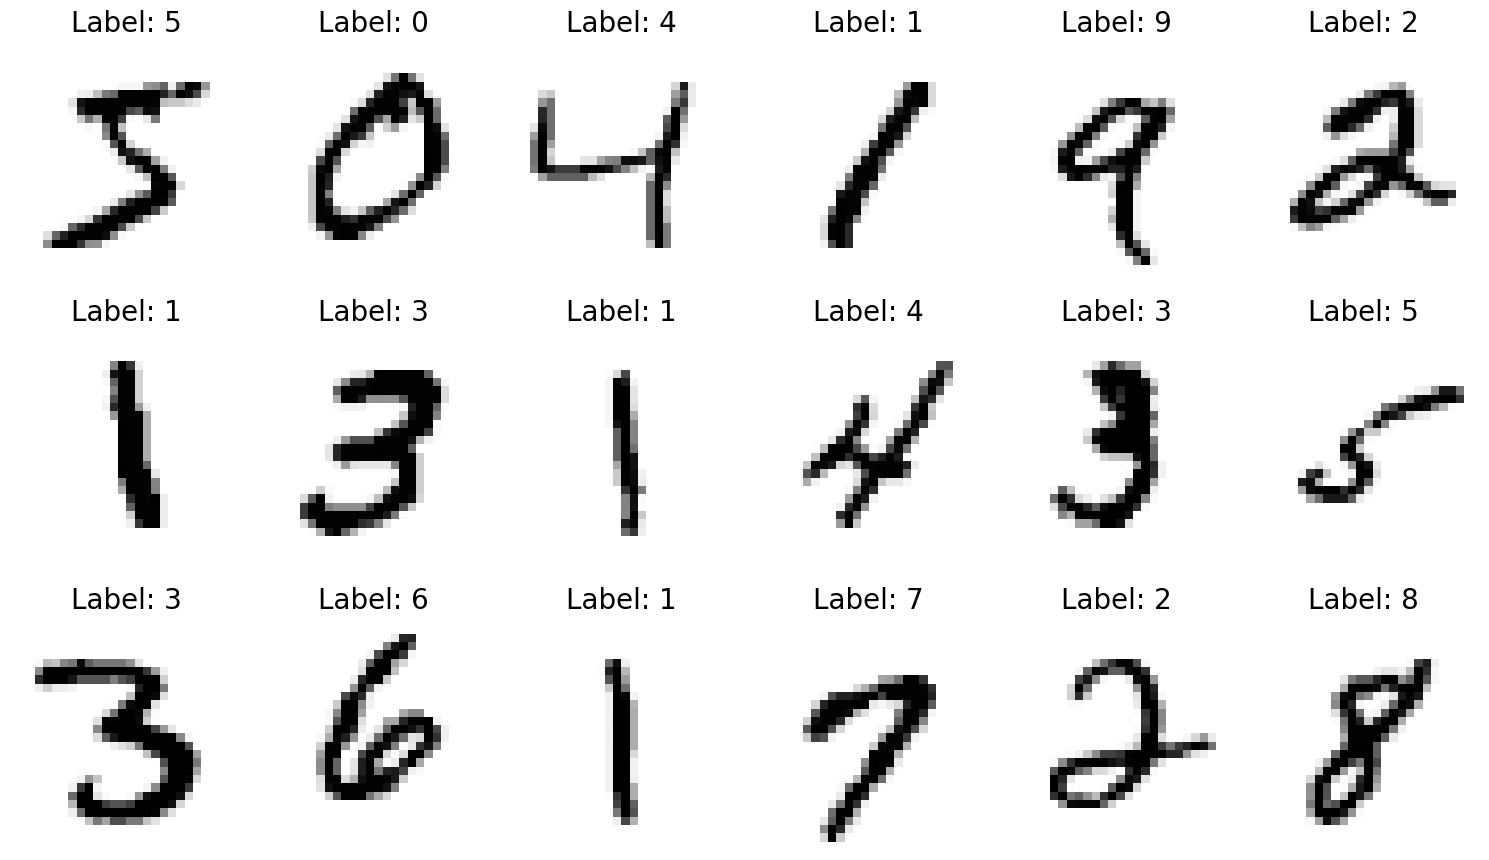

In [3]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(15, 9))
for i in range(18):
    plt.subplot(3, 6, i + 1)
    training_data, training_groundtruths = mnist_train[i]
    plt.title(f"Label: {training_groundtruths}", fontsize=20)
    plt.imshow(training_data.squeeze(), cmap="Greys") 
    plt.axis("off")

plt.tight_layout()
plt.show()

In [4]:
import deeplay as dl
import itertools
def get_all_valid_dims(min_number_of_parameters, max_number_of_parameters):
    
    for depth in range(1, 5):
        for hidden_dims in itertools.product([8, 16, 32, 64, 128, 256, 512], repeat=depth):
            
            params = 28 * 28 * hidden_dims[0]
            for i in range(1, len(hidden_dims) - 1):
                params += hidden_dims[i] * hidden_dims[i + 1]
            params += hidden_dims[-1] * 10
            if min_number_of_parameters <= params <= max_number_of_parameters:
                yield hidden_dims




 Here, we have chosen to assign the `groundtruth_digit` to the second axis and `predicted_digit` to the first axis, but the opposite is also a valid (and comon) choice.

In [6]:
import optuna
import deeplay as dl
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import pytorch_lightning as pl
import pytorch_lightning.callbacks as plc
train_dataset = MNIST(root="../../data", train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST(root="../../data", train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
activation_dict = {
    'leaky_relu': nn.LeakyReLU,
    'relu': nn.ReLU,
    'tanh': nn.Tanh,
    'sigmoid': nn.Sigmoid,
    'selu': nn.SELU,
    'elu': nn.ELU,
    'gelu': nn.GELU,
}

normalization_dict = {
    'batch_norm': nn.BatchNorm1d,
    None: nn.Identity,
}

min_number_of_parameters = 800000
max_number_of_parameters = 1010000

list_of_valid_dims = list(get_all_valid_dims(min_number_of_parameters, max_number_of_parameters))


def objective(trial: optuna.Trial):
    # Load and preprocess the MNIST dataset
    
    
    
    
    # Define the search space
    input_dim = 28 * 28

    
    activations = []
    normalizations = []
    hidden_dims = []


    total_params = 0
    i = 0
    while total_params < min_number_of_parameters:

        hidden_dim = trial.suggest_int(f'hidden_dim_{i}', 8, 1024)

        if total_params == 0:
            total_params = 28 * 28 * hidden_dim
        else:
            total_params += hidden_dims[-1] * hidden_dim

        total_params_with_output = total_params + hidden_dim * 10

        

        hidden_dims.append(hidden_dim)
        activation_name = trial.suggest_categorical(f'activation_{i}', list(activation_dict.keys()))
        activations.append(activation_name)
        normalizations.append(trial.suggest_categorical(f'normalization_{i}', list(normalization_dict.keys())))

        i += 1

        if total_params_with_output > max_number_of_parameters:
            break

    
    
    config = (
        dl.Config()
        .model(dl.MultiLayerPerceptron, in_features=28*28, hidden_dims=hidden_dims, out_features=10)
    )
    for i in range(len(hidden_dims)):
        config = config.model.blocks[i].activation(activation_dict[activations[i]], negative_slope=0.1)
        if normalizations[i] is not None:
            config = config.model.blocks[i].normalization(normalization_dict[normalizations[i]], num_features=hidden_dims[i])
    
    # Define the model
    model = dl.Classifier.from_config(config)

    
    number_of_parameters = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {number_of_parameters}")

    if number_of_parameters < min_number_of_parameters or number_of_parameters > max_number_of_parameters:
        raise optuna.exceptions.TrialPruned()
    early_stopping = plc.EarlyStopping(patience=2, monitor='val_loss', check_on_train_epoch_end=False)

    pruner_callback = optuna.integration.PyTorchLightningPruningCallback(trial, monitor="val_accuracy")

    trainer = dl.Trainer(callbacks=[early_stopping, pruner_callback], accelerator="auto")

    # Train the model
    trainer.fit(model, train_loader, test_loader)

    model.eval()
    score = trainer.test(dataloaders=test_loader, ckpt_path='best')


    return score[0]['test_accuracy']

pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5, interval_steps=1)
study = optuna.create_study(direction='maximize', pruner=pruner, storage='sqlite:///mnist.db', study_name='mnist_medium')
study.optimize(objective, n_trials=1000000)

# Get the best trial
best_trial = study.best_trial

print(f"Best Trial: {best_trial.number}")
print(f"Best Parameters: {best_trial.params}")
print(f"Best Accuracy: {best_trial.value}")

[I 2023-10-02 07:36:54,136] A new study created in RDB with name: mnist_medium
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters: 844830


c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\loops\utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 844 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
844 K     Trainable params
0         Non-trainable params
844 K     Total params
3.379     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_559\checkpoints\epoch=9-step=9380.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_559\checkpoints\epoch=9-step=9380.ckpt
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9715999960899353     │
│         test_loss         │    0.09261661022901535    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 07:40:35,369] Trial 0 finished with value: 0.9715999960899353 and parameters: {'hidden_dim_0': 682, 'activation_0': 'sigmoid', 'normalization_0': 'batch_norm', 'hidden_dim_1': 55, 'activation_1': 'sigmoid', 'normalization_1': None, 'hidden_dim_2': 546, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 296, 'activation_3': 'selu', 'normalization_3': None, 'hidden_dim_4': 249, 'activation_4': 'relu', 'normalization_4': 'batch_norm'}. Best is trial 0 with value: 0.9715999960899353.
[I 2023-10-02 07:40:35,523] Trial 1 pruned. 


Number of parameters: 1439975


[I 2023-10-02 07:40:35,766] Trial 2 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 863 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
863 K     Trainable params
0         Non-trainable params
863 K     Total params
3.453     Total estimated model params size (MB)


Number of parameters: 1155398
Number of parameters: 863147


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_560\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_560\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9786999821662903     │
│         test_loss         │    0.08838260173797607    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 07:43:24,342] Trial 3 finished with value: 0.9786999821662903 and parameters: {'hidden_dim_0': 682, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 471, 'activation_1': 'elu', 'normalization_1': None}. Best is trial 3 with value: 0.9786999821662903.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 827 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
827 K     Trainable params
0         Non-trainable params
827 K     Total params
3.311     Total estimated model params size (MB)


Number of parameters: 827685


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_561\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_561\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9696999788284302     │
│         test_loss         │    0.10676831007003784    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 07:45:33,620] Trial 4 finished with value: 0.9696999788284302 and parameters: {'hidden_dim_0': 505, 'activation_0': 'selu', 'normalization_0': None, 'hidden_dim_1': 117, 'activation_1': 'elu', 'normalization_1': None, 'hidden_dim_2': 575, 'activation_2': 'elu', 'normalization_2': None, 'hidden_dim_3': 191, 'activation_3': 'relu', 'normalization_3': 'batch_norm', 'hidden_dim_4': 950, 'activation_4': 'elu', 'normalization_4': 'batch_norm'}. Best is trial 3 with value: 0.9786999821662903.
[I 2023-10-02 07:45:33,700] Trial 5 pruned. 
[I 2023-10-02 07:45:33,855] Trial 6 pruned. 


Number of parameters: 1077859
Number of parameters: 1435363


[I 2023-10-02 07:45:33,972] Trial 7 pruned. 
[I 2023-10-02 07:45:34,049] Trial 8 pruned. 


Number of parameters: 1165909
Number of parameters: 1364429
Number of parameters: 1078356


[I 2023-10-02 07:45:34,161] Trial 9 pruned. 
[I 2023-10-02 07:45:34,274] Trial 10 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters: 1062529
Number of parameters: 975663


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 975 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
975 K     Trainable params
0         Non-trainable params
975 K     Total params
3.903     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_562\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_562\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9768999814987183     │
│         test_loss         │    0.09455723315477371    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 07:48:19,765] Trial 11 finished with value: 0.9768999814987183 and parameters: {'hidden_dim_0': 676, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 11, 'activation_1': 'relu', 'normalization_1': None, 'hidden_dim_2': 833, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 503, 'activation_3': 'selu', 'normalization_3': None}. Best is trial 3 with value: 0.9786999821662903.
[I 2023-10-02 07:48:19,850] Trial 12 pruned. 
[I 2023-10-02 07:48:19,957] Trial 13 pruned. 


Number of parameters: 1016453
Number of parameters: 1050063


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 880 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
880 K     Trainable params
0         Non-trainable params
880 K     Total params
3.522     Total estimated model params size (MB)


Number of parameters: 880512


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_563\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_563\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9711999893188477     │
│         test_loss         │    0.10004545003175735    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 07:49:40,737] Trial 14 finished with value: 0.9711999893188477 and parameters: {'hidden_dim_0': 724, 'activation_0': 'elu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 200, 'activation_1': 'leaky_relu', 'normalization_1': None, 'hidden_dim_2': 778, 'activation_2': 'tanh', 'normalization_2': 'batch_norm'}. Best is trial 3 with value: 0.9786999821662903.
[I 2023-10-02 07:49:40,872] Trial 15 pruned. 
[I 2023-10-02 07:49:40,981] Trial 16 pruned. 


Number of parameters: 1261547
Number of parameters: 1298122
Number of parameters: 950087


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 950 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
950 K     Trainable params
0         Non-trainable params
950 K     Total params
3.800     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_564\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_564\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9797999858856201     │
│         test_loss         │    0.07582344859838486    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 07:52:12,052] Trial 17 finished with value: 0.9797999858856201 and parameters: {'hidden_dim_0': 871, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 300, 'activation_1': 'leaky_relu', 'normalization_1': None}. Best is trial 17 with value: 0.9797999858856201.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 972 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
972 K     Trainable params
0         Non-trainable params
972 K     Total params
3.888     Total estimated model params size (MB)


Number of parameters: 972020


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_565\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_565\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9758999943733215     │
│         test_loss         │    0.08887138962745667    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 07:54:41,195] Trial 18 finished with value: 0.9758999943733215 and parameters: {'hidden_dim_0': 884, 'activation_0': 'elu', 'normalization_0': None, 'hidden_dim_1': 310, 'activation_1': 'leaky_relu', 'normalization_1': 'batch_norm'}. Best is trial 17 with value: 0.9797999858856201.
[I 2023-10-02 07:54:41,280] Trial 19 pruned. 


Number of parameters: 1067609


[I 2023-10-02 07:54:41,659] Trial 20 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 826 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
826 K     Trainable params
0         Non-trainable params
826 K     Total params
3.306     Total estimated model params size (MB)


Number of parameters: 1349346
Number of parameters: 826517


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_566\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_566\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9772999882698059     │
│         test_loss         │    0.07854925096035004    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 07:56:21,724] Trial 21 finished with value: 0.9772999882698059 and parameters: {'hidden_dim_0': 775, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 177, 'activation_1': 'relu', 'normalization_1': None, 'hidden_dim_2': 417, 'activation_2': 'selu', 'normalization_2': 'batch_norm'}. Best is trial 17 with value: 0.9797999858856201.
[I 2023-10-02 07:56:21,807] Trial 22 pruned. 
[I 2023-10-02 07:56:21,940] Trial 23 pruned. 


Number of parameters: 1071951
Number of parameters: 1163895


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 821 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
821 K     Trainable params
0         Non-trainable params
821 K     Total params
3.285     Total estimated model params size (MB)


Number of parameters: 821194


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_567\checkpoints\epoch=9-step=9380.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_567\checkpoints\epoch=9-step=9380.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818999767303467     │
│         test_loss         │    0.06651817262172699    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 07:59:58,963] Trial 24 finished with value: 0.9818999767303467 and parameters: {'hidden_dim_0': 584, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 305, 'activation_1': 'elu', 'normalization_1': None, 'hidden_dim_2': 413, 'activation_2': 'selu', 'normalization_2': None, 'hidden_dim_3': 50, 'activation_3': 'leaky_relu', 'normalization_3': 'batch_norm', 'hidden_dim_4': 571, 'activation_4': 'selu', 'normalization_4': 'batch_norm'}. Best is trial 24 with value: 0.9818999767303467.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 887 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy

Number of parameters: 887100


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 08:02:16,156] Trial 25 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 855 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
855 K     Trainable params
0         Non-trainable params
855 K     Total params
3.421     Total estimated model params size (MB)


Number of parameters: 855361


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_569\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_569\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9728000164031982     │
│         test_loss         │    0.09909215569496155    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:03:52,025] Trial 26 finished with value: 0.9728000164031982 and parameters: {'hidden_dim_0': 600, 'activation_0': 'leaky_relu', 'normalization_0': None, 'hidden_dim_1': 627, 'activation_1': 'elu', 'normalization_1': 'batch_norm'}. Best is trial 24 with value: 0.9818999767303467.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 824 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
824 K     Trainable params
0         Non-trainable params
824 K     Total params
3.297     Total estimated model params size (MB)


Number of parameters: 824287


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 08:05:47,220] Trial 27 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 864 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
864 K     Trainable params
0         Non-trainable params
864 K     Total params
3.460     Total estimated model params size (MB)


Number of parameters: 864914


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 08:07:59,954] Trial 28 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 916 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
916 K     Trainable params
0         Non-trainable params
916 K     Total params
3.666     Total estimated model params size (MB)


Number of parameters: 916441


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 08:10:09,732] Trial 29 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 981 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
981 K     Trainable params
0         Non-trainable params
981 K     Total params
3.927     Total estimated model params size (MB)


Number of parameters: 981713


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_573\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_573\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.979200005531311     │
│         test_loss         │    0.07931037992238998    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:12:21,938] Trial 30 finished with value: 0.979200005531311 and parameters: {'hidden_dim_0': 934, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 261, 'activation_1': 'elu', 'normalization_1': None}. Best is trial 24 with value: 0.9818999767303467.
[I 2023-10-02 08:12:22,027] Trial 31 pruned. 
[I 2023-10-02 08:12:22,111] Trial 32 pruned. 
[I 2023-10-02 08:12:22,193] Trial 33 pruned. 


Number of parameters: 1030121
Number of parameters: 1106957
Number of parameters: 1060388


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 891 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
891 K     Trainable params
0         Non-trainable params
891 K     Total params
3.565     Total estimated model params size (MB)


Number of parameters: 891300


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 08:14:24,890] Trial 34 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 921 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
921 K     Trainable params
0         Non-trainable params
921 K     Total params
3.686     Total estimated model params size (MB)


Number of parameters: 921401


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_575\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_575\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815999865531921     │
│         test_loss         │    0.07483353465795517    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:16:17,386] Trial 35 finished with value: 0.9815999865531921 and parameters: {'hidden_dim_0': 661, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 597, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 24 with value: 0.9818999767303467.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 901 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
901 K     Trainable params
0         Non-trainable params
901 K     Total params
3.604     Total estimated model params size (MB)


Number of parameters: 901109


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_576\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_576\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9772999882698059     │
│         test_loss         │    0.0827731043100357     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:18:17,114] Trial 36 finished with value: 0.9772999882698059 and parameters: {'hidden_dim_0': 655, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 579, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 24 with value: 0.9818999767303467.
[I 2023-10-02 08:18:17,203] Trial 37 pruned. 
[I 2023-10-02 08:18:17,316] Trial 38 pruned. 


Number of parameters: 1236883
Number of parameters: 1232687


[I 2023-10-02 08:18:17,426] Trial 39 pruned. 
[I 2023-10-02 08:18:17,515] Trial 40 pruned. 
[I 2023-10-02 08:18:17,603] Trial 41 pruned. 


Number of parameters: 1088737
Number of parameters: 1483129
Number of parameters: 1185761


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 946 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
946 K     Trainable params
0         Non-trainable params
946 K     Total params
3.787     Total estimated model params size (MB)


Number of parameters: 946769


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_577\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_577\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9825000166893005     │
│         test_loss         │    0.06640448421239853    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:20:33,162] Trial 42 finished with value: 0.9825000166893005 and parameters: {'hidden_dim_0': 647, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 665, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 42 with value: 0.9825000166893005.
[I 2023-10-02 08:20:33,262] Trial 43 pruned. 
[I 2023-10-02 08:20:33,377] Trial 44 pruned. 


Number of parameters: 1109403
Number of parameters: 1060232


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 982 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
982 K     Trainable params
0         Non-trainable params
982 K     Total params
3.930     Total estimated model params size (MB)


Number of parameters: 982551


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_578\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_578\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818999767303467     │
│         test_loss         │    0.0626535564661026     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:22:35,513] Trial 45 finished with value: 0.9818999767303467 and parameters: {'hidden_dim_0': 641, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 731, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 915 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
915 K     Trainable params
0         Non-trainable params
915 K     Total params
3.663     Total estimated model params size (MB)


Number of parameters: 915851


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_579\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_579\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9804999828338623     │
│         test_loss         │    0.06628798693418503    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:24:36,925] Trial 46 finished with value: 0.9804999828338623 and parameters: {'hidden_dim_0': 631, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 651, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 991 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
991 K     Trainable params
0         Non-trainable params
991 K     Total params
3.964     Total estimated model params size (MB)


Number of parameters: 991025


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 08:26:31,654] Trial 47 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 912 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
912 K     Trainable params
0         Non-trainable params
912 K     Total params
3.651     Total estimated model params size (MB)


Number of parameters: 912792


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_581\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_581\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9803000092506409     │
│         test_loss         │    0.07029446214437485    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:28:33,060] Trial 48 finished with value: 0.9803000092506409 and parameters: {'hidden_dim_0': 624, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 662, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 917 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
917 K     Trainable params
0         Non-trainable params
917 K     Total params
3.671     Total estimated model params size (MB)


Number of parameters: 917673


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_582\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_582\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9807000160217285     │
│         test_loss         │    0.0722789466381073     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:30:58,740] Trial 49 finished with value: 0.9807000160217285 and parameters: {'hidden_dim_0': 548, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 867, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 902 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
902 K     Trainable params
0         Non-trainable params
902 K     Total params
3.609     Total estimated model params size (MB)


Number of parameters: 902235


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_583\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_583\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9799000024795532     │
│         test_loss         │    0.07283258438110352    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:32:37,585] Trial 50 finished with value: 0.9799000024795532 and parameters: {'hidden_dim_0': 539, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 866, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 911 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
911 K     Trainable params
0         Non-trainable params
911 K     Total params
3.646     Total estimated model params size (MB)


Number of parameters: 911499


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_584\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_584\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9814000129699707     │
│         test_loss         │    0.07165893912315369    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:35:00,637] Trial 51 finished with value: 0.9814000129699707 and parameters: {'hidden_dim_0': 478, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 835, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 158, 'activation_2': 'selu', 'normalization_2': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 812 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K   

Number of parameters: 812489


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_585\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_585\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9803000092506409     │
│         test_loss         │    0.06985460966825485    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:36:43,736] Trial 52 finished with value: 0.9803000092506409 and parameters: {'hidden_dim_0': 379, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 935, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 166, 'activation_2': 'selu', 'normalization_2': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 858 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
858 K     Trainable params
0         Non-trainable params
858 K   

Number of parameters: 858349


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_586\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_586\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9787999987602234     │
│         test_loss         │    0.06988289207220078    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:39:23,322] Trial 53 finished with value: 0.9787999987602234 and parameters: {'hidden_dim_0': 473, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 791, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 9, 'activation_2': 'selu', 'normalization_2': None, 'hidden_dim_3': 500, 'activation_3': 'gelu', 'normalization_3': 'batch_norm', 'hidden_dim_4': 188, 'activation_4': 'tanh', 'normalization_4': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
[I 2023-10-02 08:39:23,487] Trial 54 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 931 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accu

Number of parameters: 1022751
Number of parameters: 931660


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_587\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_587\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9807999730110168     │
│         test_loss         │    0.06849193572998047    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:41:42,632] Trial 55 finished with value: 0.9807999730110168 and parameters: {'hidden_dim_0': 528, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 954, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
[I 2023-10-02 08:41:42,721] Trial 56 pruned. 
[I 2023-10-02 08:41:42,828] Trial 57 pruned. 


Number of parameters: 1036881
Number of parameters: 1121825


[I 2023-10-02 08:41:42,914] Trial 58 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 848 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
848 K     Trainable params
0         Non-trainable params
848 K     Total params
3.395     Total estimated model params size (MB)


Number of parameters: 1038422
Number of parameters: 848646


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_588\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_588\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9797999858856201     │
│         test_loss         │    0.06717248260974884    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:43:42,609] Trial 59 finished with value: 0.9797999858856201 and parameters: {'hidden_dim_0': 487, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 762, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 119, 'activation_2': 'elu', 'normalization_2': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 915 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
915 K     Trainable params
0         Non-trainable params
915 K    

Number of parameters: 915105


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 08:45:40,519] Trial 60 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 914 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
914 K     Trainable params
0         Non-trainable params
914 K     Total params
3.658     Total estimated model params size (MB)


Number of parameters: 914404


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_590\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_590\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9797000288963318     │
│         test_loss         │    0.0706017017364502     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:47:19,439] Trial 61 finished with value: 0.9797000288963318 and parameters: {'hidden_dim_0': 556, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 838, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 904 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
904 K     Trainable params
0         Non-trainable params
904 K     Total params
3.617     Total estimated model params size (MB)


Number of parameters: 904229


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_591\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_591\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9814000129699707     │
│         test_loss         │    0.07179923355579376    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:49:22,177] Trial 62 finished with value: 0.9814000129699707 and parameters: {'hidden_dim_0': 400, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 878, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 265, 'activation_2': 'relu', 'normalization_2': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 979 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
979 K     Trainable params
0         Non-trainable params
979 K   

Number of parameters: 979622


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 08:51:22,553] Trial 63 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 1.0 M 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.025     Total estimated model params size (MB)


Number of parameters: 1006199


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_593\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_593\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.978600025177002     │
│         test_loss         │    0.08094469457864761    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:53:41,747] Trial 64 finished with value: 0.978600025177002 and parameters: {'hidden_dim_0': 322, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 1023, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 176, 'activation_2': 'relu', 'normalization_2': None, 'hidden_dim_3': 14, 'activation_3': 'leaky_relu', 'normalization_3': 'batch_norm', 'hidden_dim_4': 394, 'activation_4': 'sigmoid', 'normalization_4': None, 'hidden_dim_5': 572, 'activation_5': 'leaky_relu', 'normalization_5': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 999 K 
1 | loss           | CrossEntropyLoss     | 

Number of parameters: 999375


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_594\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_594\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9732999801635742     │
│         test_loss         │    0.08552577346563339    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 08:55:01,524] Trial 65 finished with value: 0.9732999801635742 and parameters: {'hidden_dim_0': 593, 'activation_0': 'tanh', 'normalization_0': 'batch_norm', 'hidden_dim_1': 879, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 860 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
860 K     Trainable params
0         Non-trainable params
860 K     Total params
3.443     Total estimated model params size (MB)


Number of parameters: 860854


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 08:57:07,177] Trial 66 pruned. Trial was pruned at epoch 5.
[I 2023-10-02 08:57:07,269] Trial 67 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters: 1125027
Number of parameters: 933956


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 933 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
933 K     Trainable params
0         Non-trainable params
933 K     Total params
3.736     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 08:59:21,726] Trial 68 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 847 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
847 K     Trainable params
0         Non-trainable params
847 K     Total params
3.389     Total estimated model params size (MB)


Number of parameters: 847151


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 09:01:31,428] Trial 69 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 893 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
893 K     Trainable params
0         Non-trainable params
893 K     Total params
3.576     Total estimated model params size (MB)


Number of parameters: 893955


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 09:03:38,364] Trial 70 pruned. Trial was pruned at epoch 6.
[I 2023-10-02 09:03:38,472] Trial 71 pruned. 
[I 2023-10-02 09:03:38,559] Trial 72 pruned. 


Number of parameters: 1131535
Number of parameters: 1081695


[I 2023-10-02 09:03:38,675] Trial 73 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters: 1135625
Number of parameters: 962925



  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 962 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
962 K     Trainable params
0         Non-trainable params
962 K     Total params
3.852     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_599\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_599\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9775999784469604     │
│         test_loss         │    0.07802880555391312    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:04:56,025] Trial 74 finished with value: 0.9775999784469604 and parameters: {'hidden_dim_0': 437, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 582, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 612, 'activation_2': 'leaky_relu', 'normalization_2': None}. Best is trial 42 with value: 0.9825000166893005.
[I 2023-10-02 09:04:56,116] Trial 75 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 889 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
889 K   

Number of parameters: 1187195
Number of parameters: 889254


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_600\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_600\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9807999730110168     │
│         test_loss         │    0.07307950407266617    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:07:25,835] Trial 76 finished with value: 0.9807999730110168 and parameters: {'hidden_dim_0': 524, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 888, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 853 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
853 K     Trainable params
0         Non-trainable params
853 K     Total params
3.413     Total estimated model params size (MB)


Number of parameters: 853148


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 09:09:37,291] Trial 77 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 851 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
851 K     Trainable params
0         Non-trainable params
851 K     Total params
3.404     Total estimated model params size (MB)


Number of parameters: 851098


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_602\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_602\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818000197410583     │
│         test_loss         │    0.0675874799489975     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:11:27,790] Trial 78 finished with value: 0.9818000197410583 and parameters: {'hidden_dim_0': 524, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 820, 'activation_1': 'leaky_relu', 'normalization_1': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 936 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
936 K     Trainable params
0         Non-trainable params
936 K     Total params
3.747     Total estimated model params size (MB)


Number of parameters: 936857


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_603\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_603\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9771000146865845     │
│         test_loss         │    0.08683930337429047    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:12:42,613] Trial 79 finished with value: 0.9771000146865845 and parameters: {'hidden_dim_0': 577, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 821, 'activation_1': 'leaky_relu', 'normalization_1': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 983 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
983 K     Trainable params
0         Non-trainable params
983 K     Total params
3.934     Total estimated model params size (MB)


Number of parameters: 983443


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_604\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_604\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9811999797821045     │
│         test_loss         │    0.06998926401138306    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:14:33,693] Trial 80 finished with value: 0.9811999797821045 and parameters: {'hidden_dim_0': 627, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 768, 'activation_1': 'leaky_relu', 'normalization_1': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 962 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
962 K     Trainable params
0         Non-trainable params
962 K     Total params
3.850     Total estimated model params size (MB)


Number of parameters: 962462


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_605\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_605\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9768999814987183     │
│         test_loss         │    0.07931429147720337    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:16:07,377] Trial 81 finished with value: 0.9768999814987183 and parameters: {'hidden_dim_0': 620, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 752, 'activation_1': 'leaky_relu', 'normalization_1': None}. Best is trial 42 with value: 0.9825000166893005.
[I 2023-10-02 09:16:07,466] Trial 82 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 918 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
918 K     Trainable params
0         Non-trainable params
918 K     Total params
3.673     T

Number of parameters: 1096717
Number of parameters: 918281


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_606\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_606\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.978600025177002     │
│         test_loss         │    0.07810075581073761    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:17:22,088] Trial 83 finished with value: 0.978600025177002 and parameters: {'hidden_dim_0': 645, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 626, 'activation_1': 'leaky_relu', 'normalization_1': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 882 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
882 K     Trainable params
0         Non-trainable params
882 K     Total params
3.530     Total estimated model params size (MB)


Number of parameters: 882605


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_607\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_607\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9785000085830688     │
│         test_loss         │    0.07036841660737991    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:18:55,162] Trial 84 finished with value: 0.9785000085830688 and parameters: {'hidden_dim_0': 673, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 516, 'activation_1': 'leaky_relu', 'normalization_1': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 838 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
838 K     Trainable params
0         Non-trainable params
838 K     Total params
3.354     Total estimated model params size (MB)


Number of parameters: 838596


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 09:20:52,857] Trial 85 pruned. Trial was pruned at epoch 5.
[I 2023-10-02 09:20:52,972] Trial 86 pruned. 


Number of parameters: 1168233
Number of parameters: 981039


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 981 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
981 K     Trainable params
0         Non-trainable params
981 K     Total params
3.924     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_609\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_609\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9800999760627747     │
│         test_loss         │    0.07903628796339035    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:22:47,507] Trial 87 finished with value: 0.9800999760627747 and parameters: {'hidden_dim_0': 613, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 801, 'activation_1': 'leaky_relu', 'normalization_1': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 947 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
947 K     Trainable params
0         Non-trainable params
947 K     Total params
3.791     Total estimated model params size (MB)


Number of parameters: 947743


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 09:24:37,465] Trial 88 pruned. Trial was pruned at epoch 5.
[I 2023-10-02 09:24:37,582] Trial 89 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 854 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
854 K     Trainable params
0         Non-trainable params
854 K     Total params
3.420     Total estimated model params size (MB)


Number of parameters: 1050347
Number of parameters: 854991


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 09:26:33,933] Trial 90 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 891 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
891 K     Trainable params
0         Non-trainable params
891 K     Total params
3.565     Total estimated model params size (MB)


Number of parameters: 891171


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_612\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_612\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9779999852180481     │
│         test_loss         │    0.07428358495235443    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:28:10,520] Trial 91 finished with value: 0.9779999852180481 and parameters: {'hidden_dim_0': 521, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 901, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
[I 2023-10-02 09:28:10,642] Trial 92 pruned. 
[I 2023-10-02 09:28:10,733] Trial 93 pruned. 


Number of parameters: 1289263
Number of parameters: 1069891
Number of parameters: 993497


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 993 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
993 K     Trainable params
0         Non-trainable params
993 K     Total params
3.974     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 09:29:59,942] Trial 94 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 885 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
885 K     Trainable params
0         Non-trainable params
885 K     Total params
3.544     Total estimated model params size (MB)


Number of parameters: 885891


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_614\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_614\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9793999791145325     │
│         test_loss         │    0.07642672210931778    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:32:00,851] Trial 95 finished with value: 0.9793999791145325 and parameters: {'hidden_dim_0': 491, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 991, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 983 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
983 K     Trainable params
0         Non-trainable params
983 K     Total params
3.933     Total estimated model params size (MB)


Number of parameters: 983140


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 09:34:16,116] Trial 96 pruned. Trial was pruned at epoch 5.
[I 2023-10-02 09:34:16,208] Trial 97 pruned. 
GPU available: True (cuda), used: True


Number of parameters: 1044245
Number of parameters: 923922


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 923 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
923 K     Trainable params
0         Non-trainable params
923 K     Total params
3.696     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 09:36:20,529] Trial 98 pruned. Trial was pruned at epoch 5.
[I 2023-10-02 09:36:20,623] Trial 99 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 886 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
886 K     Trainable params
0         Non-trainable params
886 K     Total params
3.545     Total estimated model params size (MB)


Number of parameters: 1052869
Number of parameters: 886219


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 09:38:10,889] Trial 100 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 851 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
851 K     Trainable params
0         Non-trainable params
851 K     Total params
3.406     Total estimated model params size (MB)


Number of parameters: 851451


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_618\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_618\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9801999926567078     │
│         test_loss         │    0.06406978517770767    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:39:47,721] Trial 101 finished with value: 0.9801999926567078 and parameters: {'hidden_dim_0': 539, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 774, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 945 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
945 K     Trainable params
0         Non-trainable params
945 K     Total params
3.780     Total estimated model params size (MB)


Number of parameters: 945062


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_619\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_619\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.978600025177002     │
│         test_loss         │    0.07559189945459366    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:41:44,270] Trial 102 finished with value: 0.978600025177002 and parameters: {'hidden_dim_0': 558, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 886, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 978 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
978 K     Trainable params
0         Non-trainable params
978 K     Total params
3.915     Total estimated model params size (MB)


Number of parameters: 978865


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_620\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_620\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818999767303467     │
│         test_loss         │    0.06717663258314133    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:43:20,765] Trial 103 finished with value: 0.9818999767303467 and parameters: {'hidden_dim_0': 589, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 856, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 992 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
992 K     Trainable params
0         Non-trainable params
992 K     Total params
3.968     Total estimated model params size (MB)


Number of parameters: 992011


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_621\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_621\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.979200005531311     │
│         test_loss         │    0.06952834129333496    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:44:55,998] Trial 104 finished with value: 0.979200005531311 and parameters: {'hidden_dim_0': 603, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 840, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 867 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
867 K     Trainable params
0         Non-trainable params
867 K     Total params
3.471     Total estimated model params size (MB)


Number of parameters: 867840


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_622\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_622\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9811999797821045     │
│         test_loss         │    0.06882103532552719    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:47:09,835] Trial 105 finished with value: 0.9811999797821045 and parameters: {'hidden_dim_0': 588, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 674, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 952 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
952 K     Trainable params
0         Non-trainable params
952 K     Total params
3.810     Total estimated model params size (MB)

Number of parameters: 952559


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_623\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_623\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9804999828338623     │
│         test_loss         │    0.06820220500230789    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:49:23,220] Trial 106 finished with value: 0.9804999828338623 and parameters: {'hidden_dim_0': 631, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 708, 'activation_1': 'relu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 861 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
861 K     Trainable params
0         Non-trainable params
861 K     Total params
3.445     Total estimated model params size (MB)

Number of parameters: 861243


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_624\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_624\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9746000170707703     │
│         test_loss         │    0.09567252546548843    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:50:56,616] Trial 107 finished with value: 0.9746000170707703 and parameters: {'hidden_dim_0': 584, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 675, 'activation_1': 'elu', 'normalization_1': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 937 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
937 K     Trainable params
0         Non-trainable params
937 K     Total params
3.750     Total estimated model params size (MB)


Number of parameters: 937579


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_625\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_625\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815000295639038     │
│         test_loss         │    0.06967170536518097    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:53:09,757] Trial 108 finished with value: 0.9815000295639038 and parameters: {'hidden_dim_0': 664, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 613, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
[I 2023-10-02 09:53:09,854] Trial 109 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 955 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
955 K     Trainable params
0         Non-trainable params
955 K     Total params
3

Number of parameters: 1087213
Number of parameters: 955093


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_626\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_626\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9803000092506409     │
│         test_loss         │    0.06334807723760605    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:55:23,723] Trial 110 finished with value: 0.9803000092506409 and parameters: {'hidden_dim_0': 709, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 550, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 961 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
961 K     Trainable params
0         Non-trainable params
961 K     Total params
3.844     Total estimated model params size (MB)

Number of parameters: 961104


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_627\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_627\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9799000024795532     │
│         test_loss         │    0.06895783543586731    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:57:19,925] Trial 111 finished with value: 0.9799000024795532 and parameters: {'hidden_dim_0': 662, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 652, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 892 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.570     Total estimated model params size (MB)

Number of parameters: 892479


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_628\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_628\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9801999926567078     │
│         test_loss         │    0.06986125558614731    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 09:59:13,308] Trial 112 finished with value: 0.9801999926567078 and parameters: {'hidden_dim_0': 599, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 688, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
[I 2023-10-02 09:59:13,402] Trial 113 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 964 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3

Number of parameters: 1176855
Number of parameters: 964840


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_629\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_629\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9793000221252441     │
│         test_loss         │    0.07825056463479996    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:01:23,499] Trial 114 finished with value: 0.9793000221252441 and parameters: {'hidden_dim_0': 690, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 600, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 835 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
835 K     Trainable params
0         Non-trainable params
835 K     Total params
3.341     Total estimated model params size (MB)

Number of parameters: 835276


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 10:03:19,844] Trial 115 pruned. Trial was pruned at epoch 5.
[I 2023-10-02 10:03:20,201] Trial 116 pruned. 
[I 2023-10-02 10:03:20,326] Trial 117 pruned. 


Number of parameters: 1508628
Number of parameters: 1067766


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 967 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
967 K     Trainable params
0         Non-trainable params
967 K     Total params
3.871     Total estimated model params size (MB)


Number of parameters: 967833


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_631\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_631\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9739999771118164     │
│         test_loss         │    0.09732773900032043    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:04:57,240] Trial 118 finished with value: 0.9739999771118164 and parameters: {'hidden_dim_0': 625, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 746, 'activation_1': 'selu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 974 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
974 K     Trainable params
0         Non-trainable params
974 K     Total params
3.897     Total estimated model params size (MB)

Number of parameters: 974175


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_632\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_632\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9797000288963318     │
│         test_loss         │    0.06940894573926926    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:06:44,150] Trial 119 finished with value: 0.9797000288963318 and parameters: {'hidden_dim_0': 613, 'activation_0': 'relu', 'normalization_0': None, 'hidden_dim_1': 790, 'activation_1': 'leaky_relu', 'normalization_1': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 998 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
998 K     Trainable params
0         Non-trainable params
998 K     Total params
3.995     Total estimated model params size (MB)


Number of parameters: 998659


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 10:08:58,561] Trial 120 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 1.0 M 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.013     Total estimated model params size (MB)


Number of parameters: 1003254


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_634\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_634\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9779999852180481     │
│         test_loss         │    0.07563082128763199    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:10:52,316] Trial 121 finished with value: 0.9779999852180481 and parameters: {'hidden_dim_0': 530, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 360, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 195, 'activation_2': 'relu', 'normalization_2': 'batch_norm', 'hidden_dim_3': 614, 'activation_3': 'sigmoid', 'normalization_3': None, 'hidden_dim_4': 325, 'activation_4': 'sigmoid', 'normalization_4': None}. Best is trial 42 with value: 0.9825000166893005.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 881 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   

Number of parameters: 881103


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_635\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_635\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9800999760627747     │
│         test_loss         │    0.06691142916679382    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:12:29,073] Trial 122 finished with value: 0.9800999760627747 and parameters: {'hidden_dim_0': 511, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 914, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 42 with value: 0.9825000166893005.
[I 2023-10-02 10:12:29,201] Trial 123 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 964 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.859  

Number of parameters: 1140061
Number of parameters: 964835


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_636\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_636\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9828000068664551     │
│         test_loss         │    0.06795383244752884    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:14:42,963] Trial 124 finished with value: 0.9828000068664551 and parameters: {'hidden_dim_0': 583, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 849, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 982 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
982 K     Trainable params
0         Non-trainable params
982 K     Total params
3.930     Total estimated model params size (MB)


Number of parameters: 982407


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_637\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_637\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9779000282287598     │
│         test_loss         │    0.07083794474601746    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:16:37,536] Trial 125 finished with value: 0.9779000282287598 and parameters: {'hidden_dim_0': 593, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 851, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 990 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
990 K     Trainable params
0         Non-trainable params
990 K     Total params
3.963     Total estimated model params size (MB)


Number of parameters: 990732


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_638\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_638\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9807999730110168     │
│         test_loss         │    0.06744204461574554    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:19:08,112] Trial 126 finished with value: 0.9807999730110168 and parameters: {'hidden_dim_0': 484, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 670, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 51, 'activation_2': 'gelu', 'normalization_2': None, 'hidden_dim_3': 444, 'activation_3': 'tanh', 'normalization_3': None, 'hidden_dim_4': 495, 'activation_4': 'gelu', 'normalization_4': 'batch_norm'}. Best is trial 124 with value: 0.9828000068664551.
[I 2023-10-02 10:19:08,205] Trial 127 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 945 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy

Number of parameters: 1019729
Number of parameters: 945525


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_639\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_639\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9807000160217285     │
│         test_loss         │    0.06658011674880981    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:20:58,423] Trial 128 finished with value: 0.9807000160217285 and parameters: {'hidden_dim_0': 581, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 822, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 124 with value: 0.9828000068664551.
[I 2023-10-02 10:20:58,544] Trial 129 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 1.0 M 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.034 

Number of parameters: 1137253
Number of parameters: 1008531


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 10:22:46,959] Trial 130 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 931 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
931 K     Trainable params
0         Non-trainable params
931 K     Total params
3.725     Total estimated model params size (MB)


Number of parameters: 931129


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_641\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_641\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9800000190734863     │
│         test_loss         │    0.07187502086162567    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:24:55,260] Trial 131 finished with value: 0.9800000190734863 and parameters: {'hidden_dim_0': 549, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 888, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 124 with value: 0.9828000068664551.
[I 2023-10-02 10:24:55,355] Trial 132 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters: 1053863
Number of parameters: 896387



  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 896 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
896 K     Trainable params
0         Non-trainable params
896 K     Total params
3.586     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_642\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_642\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9824000000953674     │
│         test_loss         │    0.06430910527706146    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:27:33,965] Trial 133 finished with value: 0.9824000000953674 and parameters: {'hidden_dim_0': 524, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 532, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 375, 'activation_2': 'tanh', 'normalization_2': None}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 908 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K 

Number of parameters: 908093


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_643\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_643\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9790999889373779     │
│         test_loss         │    0.07415153086185455    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:29:09,974] Trial 134 finished with value: 0.9790999889373779 and parameters: {'hidden_dim_0': 500, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 523, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 471, 'activation_2': 'tanh', 'normalization_2': None}. Best is trial 124 with value: 0.9828000068664551.
[I 2023-10-02 10:29:10,098] Trial 135 pruned. 
[I 2023-10-02 10:29:10,246] Trial 136 pruned. 


Number of parameters: 1037070
Number of parameters: 1135459


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 875 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
875 K     Trainable params
0         Non-trainable params
875 K     Total params
3.500     Total estimated model params size (MB)


Number of parameters: 875043


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 10:31:24,107] Trial 137 pruned. Trial was pruned at epoch 6.
[I 2023-10-02 10:31:24,226] Trial 138 pruned. 
[I 2023-10-02 10:31:24,348] Trial 139 pruned. 


Number of parameters: 1016171
Number of parameters: 1184845


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 993 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
993 K     Trainable params
0         Non-trainable params
993 K     Total params
3.975     Total estimated model params size (MB)


Number of parameters: 993639


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_645\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_645\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9789000153541565     │
│         test_loss         │    0.07054201513528824    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:32:38,978] Trial 140 finished with value: 0.9789000153541565 and parameters: {'hidden_dim_0': 689, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 643, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 862 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
862 K     Trainable params
0         Non-trainable params
862 K     Total params
3.452     Total estimated model params size (MB)


Number of parameters: 862959


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_646\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_646\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9801999926567078     │
│         test_loss         │    0.06913819164037704    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:34:13,912] Trial 141 finished with value: 0.9801999926567078 and parameters: {'hidden_dim_0': 527, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 830, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 857 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
857 K     Trainable params
0         Non-trainable params
857 K     Total params
3.429     Total estimated model params size (MB)


Number of parameters: 857343


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_647\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_647\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9782000184059143     │
│         test_loss         │    0.07390807569026947    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:35:49,619] Trial 142 finished with value: 0.9782000184059143 and parameters: {'hidden_dim_0': 509, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 875, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 978 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
978 K     Trainable params
0         Non-trainable params
978 K     Total params
3.913     Total estimated model params size (MB)


Number of parameters: 978349


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_648\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_648\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9793000221252441     │
│         test_loss         │    0.0769561156630516     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:37:42,907] Trial 143 finished with value: 0.9793000221252441 and parameters: {'hidden_dim_0': 592, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 847, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 866 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
866 K     Trainable params
0         Non-trainable params
866 K     Total params
3.465     Total estimated model params size (MB)


Number of parameters: 866203


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_649\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_649\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815000295639038     │
│         test_loss         │    0.06652762740850449    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:39:54,180] Trial 144 finished with value: 0.9815000295639038 and parameters: {'hidden_dim_0': 555, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 756, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 886 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
886 K     Trainable params
0         Non-trainable params
886 K     Total params
3.547     Total estimated model params size (MB)


Number of parameters: 886843


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_650\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_650\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9819999933242798     │
│         test_loss         │    0.06578612327575684    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:41:44,830] Trial 145 finished with value: 0.9819999933242798 and parameters: {'hidden_dim_0': 568, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 757, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 885 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
885 K     Trainable params
0         Non-trainable params
885 K     Total params
3.544     Total estimated model params size (MB)


Number of parameters: 885908


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_651\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_651\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818999767303467     │
│         test_loss         │    0.07254890352487564    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:44:13,099] Trial 146 finished with value: 0.9818999767303467 and parameters: {'hidden_dim_0': 568, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 758, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 869 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
869 K     Trainable params
0         Non-trainable params
869 K     Total params
3.478     Total estimated model params size (MB)


Number of parameters: 869481


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_652\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_652\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9814000129699707     │
│         test_loss         │    0.0718974620103836     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:46:01,097] Trial 147 finished with value: 0.9814000129699707 and parameters: {'hidden_dim_0': 557, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 759, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 884 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
884 K     Trainable params
0         Non-trainable params
884 K     Total params
3.540     Total estimated model params size (MB)


Number of parameters: 884931


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_653\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_653\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815000295639038     │
│         test_loss         │    0.07205414772033691    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:47:49,389] Trial 148 finished with value: 0.9815000295639038 and parameters: {'hidden_dim_0': 570, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 751, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 902 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
902 K     Trainable params
0         Non-trainable params
902 K     Total params
3.611     Total estimated model params size (MB)


Number of parameters: 902699


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_654\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_654\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9778000116348267     │
│         test_loss         │    0.07998614758253098    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:49:19,602] Trial 149 finished with value: 0.9778000116348267 and parameters: {'hidden_dim_0': 568, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 787, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 822 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
822 K     Trainable params
0         Non-trainable params
822 K     Total params
3.288     Total estimated model params size (MB)


Number of parameters: 822113


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_655\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_655\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9803000092506409     │
│         test_loss         │    0.06936431676149368    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:51:07,370] Trial 150 finished with value: 0.9803000092506409 and parameters: {'hidden_dim_0': 541, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 718, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 860 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
860 K     Trainable params
0         Non-trainable params
860 K     Total params
3.442     Total estimated model params size (MB)


Number of parameters: 860477


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_656\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_656\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9812999963760376     │
│         test_loss         │    0.06404412537813187    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:52:55,064] Trial 151 finished with value: 0.9812999963760376 and parameters: {'hidden_dim_0': 553, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 754, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 124 with value: 0.9828000068664551.
[I 2023-10-02 10:52:55,188] Trial 152 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 910 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
910 K     Trainable params
0         Non-trainable params
910 K     Total params
3.640     Tota

Number of parameters: 1047867
Number of parameters: 910073


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_657\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_657\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9828000068664551     │
│         test_loss         │    0.06874620169401169    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:54:42,917] Trial 153 finished with value: 0.9828000068664551 and parameters: {'hidden_dim_0': 565, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 808, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 984 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
984 K     Trainable params
0         Non-trainable params
984 K     Total params
3.936     Total estimated model params size (MB)


Number of parameters: 984065


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_658\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_658\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9796000123023987     │
│         test_loss         │    0.07835157215595245    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:56:30,848] Trial 154 finished with value: 0.9796000123023987 and parameters: {'hidden_dim_0': 611, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 809, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 914 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
914 K     Trainable params
0         Non-trainable params
914 K     Total params
3.656     Total estimated model params size (MB)


Number of parameters: 914117


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_659\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_659\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9811999797821045     │
│         test_loss         │    0.06645873934030533    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 10:58:01,296] Trial 155 finished with value: 0.9811999797821045 and parameters: {'hidden_dim_0': 576, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 785, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 124 with value: 0.9828000068664551.
[I 2023-10-02 10:58:01,393] Trial 156 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 900 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
900 K     Trainable params
0         Non-trainable params
900 K     Total params
3.600     Tota

Number of parameters: 1055732
Number of parameters: 900073


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 10:59:47,102] Trial 157 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 970 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
970 K     Trainable params
0         Non-trainable params
970 K     Total params
3.881     Total estimated model params size (MB)


Number of parameters: 970369


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 11:01:52,021] Trial 158 pruned. Trial was pruned at epoch 5.
[I 2023-10-02 11:01:52,148] Trial 159 pruned. 
[I 2023-10-02 11:01:52,272] Trial 160 pruned. 


Number of parameters: 1045191
Number of parameters: 1111466


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 885 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
885 K     Trainable params
0         Non-trainable params
885 K     Total params
3.543     Total estimated model params size (MB)


Number of parameters: 885806


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_662\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_662\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9817000031471252     │
│         test_loss         │    0.07410787045955658    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:04:20,740] Trial 161 finished with value: 0.9817000031471252 and parameters: {'hidden_dim_0': 562, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 774, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 124 with value: 0.9828000068664551.


Number of parameters: 904341


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 904 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
904 K     Trainable params
0         Non-trainable params
904 K     Total params
3.617     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_663\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_663\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9804999828338623     │
│         test_loss         │    0.06888772547245026    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:06:09,343] Trial 162 finished with value: 0.9804999828338623 and parameters: {'hidden_dim_0': 575, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 771, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 872 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
872 K     Trainable params
0         Non-trainable params
872 K     Total params
3.489     Total estimated model params size (MB)


Number of parameters: 872345


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_664\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_664\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9789000153541565     │
│         test_loss         │    0.07053567469120026    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:08:00,131] Trial 163 finished with value: 0.9789000153541565 and parameters: {'hidden_dim_0': 541, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 809, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 124 with value: 0.9828000068664551.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 927 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
927 K     Trainable params
0         Non-trainable params
927 K     Total params
3.709     Total estimated model params size (MB)


Number of parameters: 927288


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_665\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_665\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9829000234603882     │
│         test_loss         │    0.06900058686733246    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:10:09,047] Trial 164 finished with value: 0.9829000234603882 and parameters: {'hidden_dim_0': 584, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 786, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 926 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
926 K     Trainable params
0         Non-trainable params
926 K     Total params
3.707     Total estimated model params size (MB)


Number of parameters: 926683


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_666\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_666\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9797000288963318     │
│         test_loss         │    0.07504252344369888    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:11:55,356] Trial 165 finished with value: 0.9797000288963318 and parameters: {'hidden_dim_0': 594, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 759, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 941 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
941 K     Trainable params
0         Non-trainable params
941 K     Total params
3.765     Total estimated model params size (MB)


Number of parameters: 941313


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_667\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_667\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9794999957084656     │
│         test_loss         │    0.06857238709926605    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:13:24,550] Trial 166 finished with value: 0.9794999957084656 and parameters: {'hidden_dim_0': 624, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 709, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 898 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
898 K     Trainable params
0         Non-trainable params
898 K     Total params
3.596     Total estimated model params size (MB)


Number of parameters: 898985


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_668\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_668\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9793999791145325     │
│         test_loss         │    0.06844537705183029    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:15:11,097] Trial 167 finished with value: 0.9793999791145325 and parameters: {'hidden_dim_0': 562, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 797, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 938 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
938 K     Trainable params
0         Non-trainable params
938 K     Total params
3.754     Total estimated model params size (MB)


Number of parameters: 938425


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_669\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_669\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.98089998960495      │
│         test_loss         │    0.06826077401638031    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:16:40,675] Trial 168 finished with value: 0.98089998960495 and parameters: {'hidden_dim_0': 593, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 781, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 823 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
823 K     Trainable params
0         Non-trainable params
823 K     Total params
3.292     Total estimated model params size (MB)


Number of parameters: 823065


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_670\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_670\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9771999716758728     │
│         test_loss         │    0.08850841969251633    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:18:16,044] Trial 169 finished with value: 0.9771999716758728 and parameters: {'hidden_dim_0': 524, 'activation_0': 'relu', 'normalization_0': None, 'hidden_dim_1': 327, 'activation_1': 'sigmoid', 'normalization_1': None, 'hidden_dim_2': 706, 'activation_2': 'elu', 'normalization_2': 'batch_norm'}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 980 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
980 K     Trainable params
0         Non-trainable params
980 K     To

Number of parameters: 980003


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_671\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_671\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9786999821662903     │
│         test_loss         │    0.0776529386639595     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:19:47,173] Trial 170 finished with value: 0.9786999821662903 and parameters: {'hidden_dim_0': 639, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 734, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 946 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
946 K     Trainable params
0         Non-trainable params
946 K     Total params
3.786     Total estimated model params size (MB)


Number of parameters: 946533


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_672\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_672\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9796000123023987     │
│         test_loss         │    0.07545877993106842    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:21:35,908] Trial 171 finished with value: 0.9796000123023987 and parameters: {'hidden_dim_0': 575, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 843, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 888 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
888 K     Trainable params
0         Non-trainable params
888 K     Total params
3.555     Total estimated model params size (MB)


Number of parameters: 888651


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_673\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_673\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9790999889373779     │
│         test_loss         │    0.07372435927391052    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:23:47,272] Trial 172 finished with value: 0.9790999889373779 and parameters: {'hidden_dim_0': 546, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 821, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 1.0 M 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.027     Total estimated model params size (MB)


Number of parameters: 1006718


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_674\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_674\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9790999889373779     │
│         test_loss         │    0.08200404047966003    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:25:53,502] Trial 173 finished with value: 0.9790999889373779 and parameters: {'hidden_dim_0': 604, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 864, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 164 with value: 0.9829000234603882.
[I 2023-10-02 11:25:53,603] Trial 174 pruned. 


Number of parameters: 1050335


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 889 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
889 K     Trainable params
0         Non-trainable params
889 K     Total params
3.559     Total estimated model params size (MB)


Number of parameters: 889654


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_675\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_675\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9817000031471252     │
│         test_loss         │    0.06471565365791321    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:27:59,767] Trial 175 finished with value: 0.9817000031471252 and parameters: {'hidden_dim_0': 562, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 778, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 888 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
888 K     Trainable params
0         Non-trainable params
888 K     Total params
3.556     Total estimated model params size (MB

Number of parameters: 888928


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_676\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_676\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9775999784469604     │
│         test_loss         │    0.08254452794790268    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:30:02,324] Trial 176 finished with value: 0.9775999784469604 and parameters: {'hidden_dim_0': 564, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 774, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 164 with value: 0.9829000234603882.
[I 2023-10-02 11:30:02,455] Trial 177 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 878 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
878 K     Trainable params
0         Non-trainable params
878 K     Total params
3.514   

Number of parameters: 1416175
Number of parameters: 878539


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_677\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_677\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815999865531921     │
│         test_loss         │    0.07004555314779282    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:32:21,988] Trial 178 finished with value: 0.9815999865531921 and parameters: {'hidden_dim_0': 620, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 619, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 877 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.510     Total estimated model params size (MB)


Number of parameters: 877535


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 11:34:06,490] Trial 179 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 827 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
827 K     Trainable params
0         Non-trainable params
827 K     Total params
3.309     Total estimated model params size (MB)


Number of parameters: 827153


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 11:35:51,233] Trial 180 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 847 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
847 K     Trainable params
0         Non-trainable params
847 K     Total params
3.389     Total estimated model params size (MB)


Number of parameters: 847355


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 11:37:36,898] Trial 181 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 847 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
847 K     Trainable params
0         Non-trainable params
847 K     Total params
3.389     Total estimated model params size (MB)


Number of parameters: 847182


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_681\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_681\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9814000129699707     │
│         test_loss         │    0.06839940696954727    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:39:25,201] Trial 182 finished with value: 0.9814000129699707 and parameters: {'hidden_dim_0': 548, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 744, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 164 with value: 0.9829000234603882.
[I 2023-10-02 11:39:25,329] Trial 183 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 850 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
850 K     Trainable params
0         Non-trainable params
850 K     Total params
3.402   

Number of parameters: 1105149
Number of parameters: 850557


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_682\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_682\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9787999987602234     │
│         test_loss         │    0.07234834134578705    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:41:49,943] Trial 184 finished with value: 0.9787999987602234 and parameters: {'hidden_dim_0': 569, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 692, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 813 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
813 K     Trainable params
0         Non-trainable params
813 K     Total params
3.253     Total estimated model params size (MB

Number of parameters: 813255


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 11:43:36,970] Trial 185 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 839 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
839 K     Trainable params
0         Non-trainable params
839 K     Total params
3.360     Total estimated model params size (MB)


Number of parameters: 839965


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 11:45:21,218] Trial 186 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 945 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
945 K     Trainable params
0         Non-trainable params
945 K     Total params
3.782     Total estimated model params size (MB)


Number of parameters: 945439


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_685\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_685\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9805999994277954     │
│         test_loss         │    0.07259435951709747    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:47:27,802] Trial 187 finished with value: 0.9805999994277954 and parameters: {'hidden_dim_0': 697, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 559, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 992 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
992 K     Trainable params
0         Non-trainable params
992 K     Total params
3.971     Total estimated model params size (MB

Number of parameters: 992672


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_686\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_686\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9801999926567078     │
│         test_loss         │    0.07089157402515411    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:49:31,402] Trial 188 finished with value: 0.9801999926567078 and parameters: {'hidden_dim_0': 616, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 810, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 164 with value: 0.9829000234603882.
[I 2023-10-02 11:49:31,501] Trial 189 pruned. 
GPU available: True (cuda), used: True


Number of parameters: 1015507
Number of parameters: 808085


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 808 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
808 K     Trainable params
0         Non-trainable params
808 K     Total params
3.232     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 11:51:22,724] Trial 190 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 956 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
956 K     Trainable params
0         Non-trainable params
956 K     Total params
3.828     Total estimated model params size (MB)


Number of parameters: 956919


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_688\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_688\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9789999723434448     │
│         test_loss         │    0.06620614975690842    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:52:53,830] Trial 191 finished with value: 0.9789999723434448 and parameters: {'hidden_dim_0': 584, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 833, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 834 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
834 K     Trainable params
0         Non-trainable params
834 K     Total params
3.338     Total estimated model params size (MB)


Number of parameters: 834515


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_689\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_689\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9793999791145325     │
│         test_loss         │    0.07237663865089417    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:54:23,916] Trial 192 finished with value: 0.9793999791145325 and parameters: {'hidden_dim_0': 523, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 789, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 828 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
828 K     Trainable params
0         Non-trainable params
828 K     Total params
3.314     Total estimated model params size (MB)


Number of parameters: 828379


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_690\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_690\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9819999933242798     │
│         test_loss         │    0.06718640774488449    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 11:56:21,473] Trial 193 finished with value: 0.9819999933242798 and parameters: {'hidden_dim_0': 400, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 851, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 134, 'activation_2': 'relu', 'normalization_2': None, 'hidden_dim_3': 384, 'activation_3': 'leaky_relu', 'normalization_3': 'batch_norm'}. Best is trial 164 with value: 0.9829000234603882.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 1.0 M 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
-------------------------------------

Number of parameters: 1008512


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 11:58:21,728] Trial 194 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 990 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
990 K     Trainable params
0         Non-trainable params
990 K     Total params
3.961     Total estimated model params size (MB)


Number of parameters: 990317


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_692\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_692\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9829999804496765     │
│         test_loss         │    0.06329233944416046    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:00:46,222] Trial 195 finished with value: 0.9829999804496765 and parameters: {'hidden_dim_0': 610, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 819, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 195 with value: 0.9829999804496765.
[I 2023-10-02 12:00:46,321] Trial 196 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 996 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
996 K     Trainable params
0         Non-trainable params
996 K     Total params
3.985 

Number of parameters: 1011459
Number of parameters: 996325


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 12:02:33,169] Trial 197 pruned. Trial was pruned at epoch 5.
[I 2023-10-02 12:02:33,296] Trial 198 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 934 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
934 K     Trainable params
0         Non-trainable params
934 K     Total params
3.737     Total estimated model params size (MB)


Number of parameters: 1211241
Number of parameters: 934223


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_694\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_694\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9811000227928162     │
│         test_loss         │    0.06943332403898239    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:04:18,846] Trial 199 finished with value: 0.9811000227928162 and parameters: {'hidden_dim_0': 578, 'activation_0': 'relu', 'normalization_0': None, 'hidden_dim_1': 813, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 195 with value: 0.9829999804496765.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 979 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
979 K     Trainable params
0         Non-trainable params
979 K     Total params
3.919     Total estimated model params size (MB)


Number of parameters: 979733


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_695\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_695\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9768999814987183     │
│         test_loss         │    0.08541400730609894    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:06:03,943] Trial 200 finished with value: 0.9768999814987183 and parameters: {'hidden_dim_0': 635, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 743, 'activation_1': 'elu', 'normalization_1': None}. Best is trial 195 with value: 0.9829999804496765.
[I 2023-10-02 12:06:04,138] Trial 201 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 957 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
957 K     Trainable params
0         Non-trainable params
957 K     Total params
3.829     Total

Number of parameters: 1066055
Number of parameters: 957239


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_696\checkpoints\epoch=9-step=9380.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_696\checkpoints\epoch=9-step=9380.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9843000173568726     │
│         test_loss         │    0.05887506157159805    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:09:01,627] Trial 202 finished with value: 0.9843000173568726 and parameters: {'hidden_dim_0': 597, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 799, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 12:09:01,761] Trial 203 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 948 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.795 

Number of parameters: 1067940
Number of parameters: 948847


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_697\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_697\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9822999835014343     │
│         test_loss         │    0.06183339282870293    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:11:24,305] Trial 204 finished with value: 0.9822999835014343 and parameters: {'hidden_dim_0': 601, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 775, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 952 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
952 K     Trainable params
0         Non-trainable params
952 K     Total params
3.810     Total estimated model params size (MB)


Number of parameters: 952587


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_698\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_698\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815000295639038     │
│         test_loss         │    0.06188373267650604    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:12:54,747] Trial 205 finished with value: 0.9815000295639038 and parameters: {'hidden_dim_0': 603, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 776, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 12:12:54,848] Trial 206 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 991 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
991 K     Trainable params
0         Non-trainable params
991 K     Total params
3.965 

Number of parameters: 1080003
Number of parameters: 991176


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_699\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_699\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9775000214576721     │
│         test_loss         │    0.07804454863071442    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:14:43,109] Trial 207 finished with value: 0.9775000214576721 and parameters: {'hidden_dim_0': 618, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 800, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 867 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
867 K     Trainable params
0         Non-trainable params
867 K     Total params
3.469     Total estimated model params size (MB)


Number of parameters: 867183


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_700\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_700\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9819999933242798     │
│         test_loss         │    0.06810081750154495    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:16:49,363] Trial 208 finished with value: 0.9819999933242798 and parameters: {'hidden_dim_0': 548, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 777, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 987 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
987 K     Trainable params
0         Non-trainable params
987 K     Total params
3.952     Total estimated model params size (MB)


Number of parameters: 987930


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_701\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_701\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.979200005531311     │
│         test_loss         │    0.07360514253377914    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:18:20,122] Trial 209 finished with value: 0.979200005531311 and parameters: {'hidden_dim_0': 596, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 852, 'activation_1': 'sigmoid', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 12:18:20,233] Trial 210 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 858 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
858 K     Trainable params
0         Non-trainable params
858 K     Total params
3.43

Number of parameters: 1029279
Number of parameters: 858027


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_702\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_702\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818000197410583     │
│         test_loss         │    0.0684070736169815     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:20:43,930] Trial 211 finished with value: 0.9818000197410583 and parameters: {'hidden_dim_0': 545, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 769, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 850 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
850 K     Trainable params
0         Non-trainable params
850 K     Total params
3.400     Total estimated model params size (MB)


Number of parameters: 850062


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_703\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_703\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9807999730110168     │
│         test_loss         │    0.06716517359018326    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:22:14,222] Trial 212 finished with value: 0.9807999730110168 and parameters: {'hidden_dim_0': 536, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 780, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 939 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
939 K     Trainable params
0         Non-trainable params
939 K     Total params
3.757     Total estimated model params size (MB)


Number of parameters: 939172


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_704\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_704\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.98089998960495      │
│         test_loss         │    0.06760178506374359    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:24:20,257] Trial 213 finished with value: 0.98089998960495 and parameters: {'hidden_dim_0': 580, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 814, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 12:24:20,391] Trial 214 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 878 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
878 K     Trainable params
0         Non-trainable params
878 K     Total params
3.512   

Number of parameters: 1145467
Number of parameters: 878095


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 12:26:06,928] Trial 215 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 950 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
950 K     Trainable params
0         Non-trainable params
950 K     Total params
3.802     Total estimated model params size (MB)


Number of parameters: 950534


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_706\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_706\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818000197410583     │
│         test_loss         │    0.06930405646562576    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:28:48,824] Trial 216 finished with value: 0.9818000197410583 and parameters: {'hidden_dim_0': 622, 'activation_0': 'leaky_relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 726, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 951 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
951 K     Trainable params
0         Non-trainable params
951 K     Total params
3.807     Total estimated model params size (MB

Number of parameters: 951749


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_707\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_707\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9776999950408936     │
│         test_loss         │    0.07245420664548874    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:30:01,847] Trial 217 finished with value: 0.9776999950408936 and parameters: {'hidden_dim_0': 597, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 790, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 956 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
956 K     Trainable params
0         Non-trainable params
956 K     Total params
3.828     Total estimated model params size (MB)


Number of parameters: 956987


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_708\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_708\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9803000092506409     │
│         test_loss         │    0.06747249513864517    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:31:50,340] Trial 218 finished with value: 0.9803000092506409 and parameters: {'hidden_dim_0': 625, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 729, 'activation_1': 'relu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 12:31:50,528] Trial 219 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 834 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
834 K     Trainable params
0         Non-trainable params
834 K     Total params
3.340 

Number of parameters: 1049313
Number of parameters: 834991


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_709\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_709\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9822999835014343     │
│         test_loss         │    0.06856276839971542    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:33:56,806] Trial 220 finished with value: 0.9822999835014343 and parameters: {'hidden_dim_0': 511, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 826, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 821 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
821 K     Trainable params
0         Non-trainable params
821 K     Total params
3.284     Total estimated model params size (MB)


Number of parameters: 821115


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_710\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_710\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9807000160217285     │
│         test_loss         │    0.0638609528541565     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:35:46,598] Trial 221 finished with value: 0.9807000160217285 and parameters: {'hidden_dim_0': 504, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 821, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 947 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
947 K     Trainable params
0         Non-trainable params
947 K     Total params
3.791     Total estimated model params size (MB)


Number of parameters: 947790


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_711\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_711\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.980400025844574     │
│         test_loss         │    0.07444208860397339    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:37:18,453] Trial 222 finished with value: 0.980400025844574 and parameters: {'hidden_dim_0': 578, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 834, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 12:37:18,558] Trial 223 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters: 1016292
Number of parameters: 845931



  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 845 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
845 K     Trainable params
0         Non-trainable params
845 K     Total params
3.384     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_712\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_712\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815999865531921     │
│         test_loss         │    0.0675954595208168     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:40:01,176] Trial 224 finished with value: 0.9815999865531921 and parameters: {'hidden_dim_0': 539, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 764, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 909 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
909 K     Trainable params
0         Non-trainable params
909 K     Total params
3.637     Total estimated model params size (MB)


Number of parameters: 909231


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_713\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_713\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.98089998960495      │
│         test_loss         │    0.06713233888149261    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:41:50,980] Trial 225 finished with value: 0.98089998960495 and parameters: {'hidden_dim_0': 566, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 801, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 12:41:51,144] Trial 226 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters: 1334406
Number of parameters: 838009



  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 838 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
838 K     Trainable params
0         Non-trainable params
838 K     Total params
3.352     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_714\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_714\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9793999791145325     │
│         test_loss         │    0.0716945081949234     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:43:05,083] Trial 227 finished with value: 0.9793999791145325 and parameters: {'hidden_dim_0': 529, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 778, 'activation_1': 'leaky_relu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 917 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
917 K     Trainable params
0         Non-trainable params
917 K     Total params
3.669     Total estimated model params size (MB

Number of parameters: 917323


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_715\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_715\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9810000061988831     │
│         test_loss         │    0.06612252444028854    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:44:54,831] Trial 228 finished with value: 0.9810000061988831 and parameters: {'hidden_dim_0': 555, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 846, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 939 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
939 K     Trainable params
0         Non-trainable params
939 K     Total params
3.759     Total estimated model params size (MB)


Number of parameters: 939739


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_716\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_716\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818000197410583     │
│         test_loss         │    0.06580931693315506    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:46:44,798] Trial 229 finished with value: 0.9818000197410583 and parameters: {'hidden_dim_0': 622, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 709, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 965 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
965 K     Trainable params
0         Non-trainable params
965 K     Total params
3.862     Total estimated model params size (MB)


Number of parameters: 965429


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_717\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_717\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9814000129699707     │
│         test_loss         │    0.06650763750076294    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:48:17,086] Trial 230 finished with value: 0.9814000129699707 and parameters: {'hidden_dim_0': 637, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 714, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 960 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
960 K     Trainable params
0         Non-trainable params
960 K     Total params
3.840     Total estimated model params size (MB)


Number of parameters: 960059


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_718\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_718\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.977400004863739     │
│         test_loss         │    0.07710999250411987    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:49:34,063] Trial 231 finished with value: 0.977400004863739 and parameters: {'hidden_dim_0': 622, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 741, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 891 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
891 K     Trainable params
0         Non-trainable params
891 K     Total params
3.567     Total estimated model params size (MB)


Number of parameters: 891833


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_719\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_719\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.978600025177002     │
│         test_loss         │    0.07514408230781555    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:51:42,116] Trial 232 finished with value: 0.978600025177002 and parameters: {'hidden_dim_0': 604, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 675, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 884 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
884 K     Trainable params
0         Non-trainable params
884 K     Total params
3.538     Total estimated model params size (MB)


Number of parameters: 884379


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_720\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_720\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9812999963760376     │
│         test_loss         │    0.06550077348947525    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:53:49,971] Trial 233 finished with value: 0.9812999963760376 and parameters: {'hidden_dim_0': 587, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 704, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 12:53:50,075] Trial 234 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 985 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
985 K     Trainable params
0         Non-trainable params
985 K     Total params
3.942 

Number of parameters: 1011011
Number of parameters: 985441


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 12:55:35,488] Trial 235 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 849 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
849 K     Trainable params
0         Non-trainable params
849 K     Total params
3.398     Total estimated model params size (MB)


Number of parameters: 849594


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 12:57:24,175] Trial 236 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 827 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
827 K     Trainable params
0         Non-trainable params
827 K     Total params
3.310     Total estimated model params size (MB)


Number of parameters: 827531


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_723\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_723\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9779000282287598     │
│         test_loss         │    0.07019790261983871    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 12:59:31,994] Trial 237 finished with value: 0.9779000282287598 and parameters: {'hidden_dim_0': 516, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 68, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 536, 'activation_2': 'sigmoid', 'normalization_2': None, 'hidden_dim_3': 435, 'activation_3': 'relu', 'normalization_3': 'batch_norm', 'hidden_dim_4': 256, 'activation_4': 'elu', 'normalization_4': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 933 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accurac

Number of parameters: 933099


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_724\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_724\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9801999926567078     │
│         test_loss         │    0.0893196389079094     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:01:50,861] Trial 238 finished with value: 0.9801999926567078 and parameters: {'hidden_dim_0': 595, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 769, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 927 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
927 K     Trainable params
0         Non-trainable params
927 K     Total params
3.709     Total estimated model params size (MB)


Number of parameters: 927282


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_725\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_725\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.982200026512146     │
│         test_loss         │    0.06720678508281708    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:04:17,252] Trial 239 finished with value: 0.982200026512146 and parameters: {'hidden_dim_0': 634, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 662, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 975 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
975 K     Trainable params
0         Non-trainable params
975 K     Total params
3.902     Total estimated model params size (MB)


Number of parameters: 975610


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 13:06:04,805] Trial 240 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 902 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
902 K     Trainable params
0         Non-trainable params
902 K     Total params
3.609     Total estimated model params size (MB)


Number of parameters: 902205


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_727\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_727\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9817000031471252     │
│         test_loss         │    0.0654536709189415     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:08:12,876] Trial 241 finished with value: 0.9817000031471252 and parameters: {'hidden_dim_0': 618, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 659, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 833 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
833 K     Trainable params
0         Non-trainable params
833 K     Total params
3.333     Total estimated model params size (MB)


Number of parameters: 833298


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_728\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_728\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9800999760627747     │
│         test_loss         │    0.07744850218296051    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:10:20,354] Trial 242 finished with value: 0.9800999760627747 and parameters: {'hidden_dim_0': 574, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 650, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 986 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
986 K     Trainable params
0         Non-trainable params
986 K     Total params
3.945     Total estimated model params size (MB)


Number of parameters: 986355


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_729\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_729\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.979200005531311     │
│         test_loss         │    0.07058729976415634    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:11:34,047] Trial 243 finished with value: 0.979200005531311 and parameters: {'hidden_dim_0': 659, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 696, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 810 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
810 K     Trainable params
0         Non-trainable params
810 K     Total params
3.242     Total estimated model params size (MB)


Number of parameters: 810399


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_730\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_730\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9801999926567078     │
│         test_loss         │    0.07516216486692429    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:13:42,018] Trial 244 finished with value: 0.9801999926567078 and parameters: {'hidden_dim_0': 551, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 668, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 980 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
980 K     Trainable params
0         Non-trainable params
980 K     Total params
3.924     Total estimated model params size (MB)


Number of parameters: 980923


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_731\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_731\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9835000038146973     │
│         test_loss         │    0.06535130739212036    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:16:25,202] Trial 245 finished with value: 0.9835000038146973 and parameters: {'hidden_dim_0': 603, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 822, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 980 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
980 K     Trainable params
0         Non-trainable params
980 K     Total params
3.920     Total estimated model params size (MB)


Number of parameters: 980064


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_732\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_732\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9830999970436096     │
│         test_loss         │   0.061529625207185745    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:19:08,598] Trial 246 finished with value: 0.9830999970436096 and parameters: {'hidden_dim_0': 604, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 818, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 971 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
971 K     Trainable params
0         Non-trainable params
971 K     Total params
3.885     Total estimated model params size (MB)


Number of parameters: 971192


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 13:20:56,097] Trial 247 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 958 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
958 K     Trainable params
0         Non-trainable params
958 K     Total params
3.834     Total estimated model params size (MB)


Number of parameters: 958539


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 13:22:43,565] Trial 248 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 946 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
946 K     Trainable params
0         Non-trainable params
946 K     Total params
3.788     Total estimated model params size (MB)


Number of parameters: 946947


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_735\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_735\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9804999828338623     │
│         test_loss         │    0.06373626738786697    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:24:33,303] Trial 249 finished with value: 0.9804999828338623 and parameters: {'hidden_dim_0': 565, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 869, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 961 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
961 K     Trainable params
0         Non-trainable params
961 K     Total params
3.847     Total estimated model params size (MB)


Number of parameters: 961827


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_736\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_736\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9789999723434448     │
│         test_loss         │    0.0666138306260109     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:26:05,001] Trial 250 finished with value: 0.9789999723434448 and parameters: {'hidden_dim_0': 603, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 791, 'activation_1': 'leaky_relu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 884 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
884 K     Trainable params
0         Non-trainable params
884 K     Total params
3.540     Total estimated model params size (MB

Number of parameters: 884878


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_737\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_737\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9800999760627747     │
│         test_loss         │    0.06792691349983215    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:27:19,153] Trial 251 finished with value: 0.9800999760627747 and parameters: {'hidden_dim_0': 544, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 820, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 860 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
860 K     Trainable params
0         Non-trainable params
860 K     Total params
3.441     Total estimated model params size (MB)


Number of parameters: 860345


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 13:29:20,837] Trial 252 pruned. Trial was pruned at epoch 5.
[I 2023-10-02 13:29:20,942] Trial 253 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 834 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
834 K     Trainable params
0         Non-trainable params
834 K     Total params
3.337     Total estimated model params size (MB)


Number of parameters: 1035891
Number of parameters: 834215


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_739\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_739\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9790999889373779     │
│         test_loss         │    0.0769352987408638     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:31:32,006] Trial 254 finished with value: 0.9790999889373779 and parameters: {'hidden_dim_0': 529, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 771, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 894 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
894 K     Trainable params
0         Non-trainable params
894 K     Total params
3.577     Total estimated model params size (MB)


Number of parameters: 894284


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_740\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_740\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9819999933242798     │
│         test_loss         │    0.06040488928556442    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:34:02,183] Trial 255 finished with value: 0.9819999933242798 and parameters: {'hidden_dim_0': 497, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 790, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 135, 'activation_2': 'tanh', 'normalization_2': None}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 911 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
911 K     Trainable params
0         Non-trainable params
911 K 

Number of parameters: 911135


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 13:35:51,986] Trial 256 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 957 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
957 K     Trainable params
0         Non-trainable params
957 K     Total params
3.832     Total estimated model params size (MB)


Number of parameters: 957895


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_742\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_742\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9793999791145325     │
│         test_loss         │    0.07267702370882034    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:37:25,296] Trial 257 finished with value: 0.9793999791145325 and parameters: {'hidden_dim_0': 445, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 882, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 238, 'activation_2': 'tanh', 'normalization_2': None}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 845 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
845 K     Trainable params
0         Non-trainable params
845 K 

Number of parameters: 845962


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_743\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_743\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9799000024795532     │
│         test_loss         │    0.07125528901815414    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:40:11,028] Trial 258 finished with value: 0.9799000024795532 and parameters: {'hidden_dim_0': 483, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 820, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 81, 'activation_2': 'tanh', 'normalization_2': None}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 861 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
861 K     Trainable params
0         Non-trainable params
861 K  

Number of parameters: 861195


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_744\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_744\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9810000061988831     │
│         test_loss         │     0.068181112408638     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:42:17,754] Trial 259 finished with value: 0.9810000061988831 and parameters: {'hidden_dim_0': 519, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 851, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 940 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
940 K     Trainable params
0         Non-trainable params
940 K     Total params
3.764     Total estimated model params size (MB)


Number of parameters: 940883


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 13:44:04,055] Trial 260 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 909 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
909 K     Trainable params
0         Non-trainable params
909 K     Total params
3.637     Total estimated model params size (MB)


Number of parameters: 909337


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_746\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_746\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9789999723434448     │
│         test_loss         │    0.07155264168977737    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:45:37,004] Trial 261 finished with value: 0.9789999723434448 and parameters: {'hidden_dim_0': 465, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 829, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 185, 'activation_2': 'tanh', 'normalization_2': None}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 895 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
895 K     Trainable params
0         Non-trainable params
895 K 

Number of parameters: 895160


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_747\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_747\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.98089998960495      │
│         test_loss         │    0.06860506534576416    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:47:28,743] Trial 262 finished with value: 0.98089998960495 and parameters: {'hidden_dim_0': 494, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 790, 'activation_1': 'relu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 142, 'activation_2': 'leaky_relu', 'normalization_2': None}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 13:47:28,853] Trial 263 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 840 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
840 K     Tra

Number of parameters: 1031675
Number of parameters: 840195


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_748\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_748\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9825000166893005     │
│         test_loss         │    0.07533828914165497    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:49:32,259] Trial 264 finished with value: 0.9825000166893005 and parameters: {'hidden_dim_0': 541, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 750, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 828 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
828 K     Trainable params
0         Non-trainable params
828 K     Total params
3.315     Total estimated model params size (MB)


Number of parameters: 828677


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_749\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_749\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9742000102996826     │
│         test_loss         │    0.09186775237321854    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:50:43,752] Trial 265 finished with value: 0.9742000102996826 and parameters: {'hidden_dim_0': 536, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 743, 'activation_1': 'leaky_relu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 892 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.568     Total estimated model params size (MB)


Number of parameters: 892065


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_750\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_750\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.982200026512146     │
│         test_loss         │    0.06738804280757904    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:53:07,864] Trial 266 finished with value: 0.982200026512146 and parameters: {'hidden_dim_0': 581, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 732, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 899 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
899 K     Trainable params
0         Non-trainable params
899 K     Total params
3.599     Total estimated model params size (MB)


Number of parameters: 899709


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_751\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_751\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818999767303467     │
│         test_loss         │    0.07205751538276672    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:55:11,598] Trial 267 finished with value: 0.9818999767303467 and parameters: {'hidden_dim_0': 579, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 752, 'activation_1': 'elu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 851 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
851 K     Trainable params
0         Non-trainable params
851 K     Total params
3.406     Total estimated model params size (MB)


Number of parameters: 851484


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_752\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_752\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9750999808311462     │
│         test_loss         │    0.09440620243549347    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:56:23,346] Trial 268 finished with value: 0.9750999808311462 and parameters: {'hidden_dim_0': 544, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 762, 'activation_1': 'elu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 925 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
925 K     Trainable params
0         Non-trainable params
925 K     Total params
3.703     Total estimated model params size (MB)


Number of parameters: 925757


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_753\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_753\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9789000153541565     │
│         test_loss         │    0.07572665065526962    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 13:57:52,654] Trial 269 finished with value: 0.9789000153541565 and parameters: {'hidden_dim_0': 579, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 796, 'activation_1': 'elu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 847 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
847 K     Trainable params
0         Non-trainable params
847 K     Total params
3.392     Total estimated model params size (MB)


Number of parameters: 847973


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 13:59:37,094] Trial 270 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 869 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
869 K     Trainable params
0         Non-trainable params
869 K     Total params
3.479     Total estimated model params size (MB)


Number of parameters: 869747


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 14:01:21,380] Trial 271 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 956 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
956 K     Trainable params
0         Non-trainable params
956 K     Total params
3.825     Total estimated model params size (MB)


Number of parameters: 956348


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 14:03:05,397] Trial 272 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 838 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
838 K     Trainable params
0         Non-trainable params
838 K     Total params
3.352     Total estimated model params size (MB)


Number of parameters: 838093


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_757\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_757\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815999865531921     │
│         test_loss         │    0.07117707282304764    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:05:09,480] Trial 273 finished with value: 0.9815999865531921 and parameters: {'hidden_dim_0': 528, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 783, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 880 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
880 K     Trainable params
0         Non-trainable params
880 K     Total params
3.520     Total estimated model params size (MB)


Number of parameters: 880112


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_758\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_758\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9805999994277954     │
│         test_loss         │    0.07151598483324051    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:07:13,743] Trial 274 finished with value: 0.9805999994277954 and parameters: {'hidden_dim_0': 548, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 802, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 972 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
972 K     Trainable params
0         Non-trainable params
972 K     Total params
3.890     Total estimated model params size (MB)


Number of parameters: 972443


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_759\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_759\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9786999821662903     │
│         test_loss         │    0.07933823764324188    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:08:42,693] Trial 275 finished with value: 0.9786999821662903 and parameters: {'hidden_dim_0': 574, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 889, 'activation_1': 'selu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 970 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
970 K     Trainable params
0         Non-trainable params
970 K     Total params
3.880     Total estimated model params size (MB)


Number of parameters: 970075


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_760\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_760\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9787999987602234     │
│         test_loss         │    0.07731280475854874    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:10:11,667] Trial 276 finished with value: 0.9787999987602234 and parameters: {'hidden_dim_0': 597, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 822, 'activation_1': 'tanh', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 869 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
869 K     Trainable params
0         Non-trainable params
869 K     Total params
3.479     Total estimated model params size (MB)


Number of parameters: 869637


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_761\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_761\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9832000136375427     │
│         test_loss         │    0.0682164877653122     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:12:49,167] Trial 277 finished with value: 0.9832000136375427 and parameters: {'hidden_dim_0': 555, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 764, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 858 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
858 K     Trainable params
0         Non-trainable params
858 K     Total params
3.435     Total estimated model params size (MB)


Number of parameters: 858703


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 14:14:49,969] Trial 278 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 878 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
878 K     Trainable params
0         Non-trainable params
878 K     Total params
3.515     Total estimated model params size (MB)


Number of parameters: 878735


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_763\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_763\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.983299970626831     │
│         test_loss         │    0.06657877564430237    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:16:36,922] Trial 279 finished with value: 0.983299970626831 and parameters: {'hidden_dim_0': 568, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 745, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 908 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.634     Total estimated model params size (MB)


Number of parameters: 908457


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_764\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_764\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9821000099182129     │
│         test_loss         │    0.0706276148557663     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:18:23,538] Trial 280 finished with value: 0.9821000099182129 and parameters: {'hidden_dim_0': 589, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 741, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 14:18:23,833] Trial 281 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 918 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
918 K     Trainable params
0         Non-trainable params
918 K     Total params
3.672     Tota

Number of parameters: 1325954
Number of parameters: 918117


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 14:20:08,864] Trial 282 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 867 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
867 K     Trainable params
0         Non-trainable params
867 K     Total params
3.471     Total estimated model params size (MB)


Number of parameters: 867641


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_766\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_766\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9805999994277954     │
│         test_loss         │    0.07205413281917572    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:21:38,547] Trial 283 finished with value: 0.9805999994277954 and parameters: {'hidden_dim_0': 560, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 747, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 920 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
920 K     Trainable params
0         Non-trainable params
920 K     Total params
3.684     Total estimated model params size (MB)


Number of parameters: 920980


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 14:23:23,779] Trial 284 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 948 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.795     Total estimated model params size (MB)


Number of parameters: 948629


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_768\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_768\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9786999821662903     │
│         test_loss         │    0.07336609065532684    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:24:51,923] Trial 285 finished with value: 0.9786999821662903 and parameters: {'hidden_dim_0': 608, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 759, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 887 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
887 K     Trainable params
0         Non-trainable params
887 K     Total params
3.552     Total estimated model params size (MB)


Number of parameters: 887917


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_769\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_769\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9821000099182129     │
│         test_loss         │    0.06728869676589966    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:26:58,962] Trial 286 finished with value: 0.9821000099182129 and parameters: {'hidden_dim_0': 355, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 799, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 399, 'activation_2': 'relu', 'normalization_2': None}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 958 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
958 K     Trainable params
0         Non-trainable params
958 K     Tota

Number of parameters: 958957


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_770\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_770\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9768999814987183     │
│         test_loss         │    0.08262597024440765    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:28:44,391] Trial 287 finished with value: 0.9768999814987183 and parameters: {'hidden_dim_0': 595, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 809, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 979 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
979 K     Trainable params
0         Non-trainable params
979 K     Total params
3.919     Total estimated model params size (MB)


Number of parameters: 979761


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_771\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_771\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9696999788284302     │
│         test_loss         │    0.10049354285001755    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:30:20,783] Trial 288 finished with value: 0.9696999788284302 and parameters: {'hidden_dim_0': 234, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 783, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 413, 'activation_2': 'relu', 'normalization_2': None, 'hidden_dim_3': 673, 'activation_3': 'selu', 'normalization_3': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 14:30:20,891] Trial 289 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters: 1053049
Number of parameters: 856215


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 856 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
856 K     Trainable params
0         Non-trainable params
856 K     Total params
3.425     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_772\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_772\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9811000227928162     │
│         test_loss         │    0.07131078094244003    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:32:09,541] Trial 290 finished with value: 0.9811000227928162 and parameters: {'hidden_dim_0': 363, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 840, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 310, 'activation_2': 'relu', 'normalization_2': None}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 899 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
899 K     Trainable params
0         Non-trainable params
899 K     Tota

Number of parameters: 899105


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 14:34:42,267] Trial 291 pruned. Trial was pruned at epoch 7.
[I 2023-10-02 14:34:42,506] Trial 292 pruned. 
[I 2023-10-02 14:34:42,613] Trial 293 pruned. 


Number of parameters: 1104864
Number of parameters: 1039075


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 943 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
943 K     Trainable params
0         Non-trainable params
943 K     Total params
3.774     Total estimated model params size (MB)


Number of parameters: 943513


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_774\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_774\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9785000085830688     │
│         test_loss         │    0.07443477213382721    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:36:17,820] Trial 294 finished with value: 0.9785000085830688 and parameters: {'hidden_dim_0': 345, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 812, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 474, 'activation_2': 'relu', 'normalization_2': None}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 14:36:17,971] Trial 295 pruned. 


Number of parameters: 1019013


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 814 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
814 K     Trainable params
0         Non-trainable params
814 K     Total params
3.258     Total estimated model params size (MB)


Number of parameters: 814449


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_775\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_775\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.979200005531311     │
│         test_loss         │    0.08450553566217422    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:39:00,037] Trial 296 finished with value: 0.979200005531311 and parameters: {'hidden_dim_0': 292, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 783, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 281, 'activation_2': 'relu', 'normalization_2': None, 'hidden_dim_3': 151, 'activation_3': 'gelu', 'normalization_3': None, 'hidden_dim_4': 557, 'activation_4': 'tanh', 'normalization_4': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 908 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy    

Number of parameters: 908271


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 14:40:48,916] Trial 297 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 956 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
956 K     Trainable params
0         Non-trainable params
956 K     Total params
3.826     Total estimated model params size (MB)


Number of parameters: 956393


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_777\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_777\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9811999797821045     │
│         test_loss         │    0.07089018076658249    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:42:54,762] Trial 298 finished with value: 0.9811999797821045 and parameters: {'hidden_dim_0': 609, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 769, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 14:42:54,875] Trial 299 pruned. 


Number of parameters: 1030889
Number of parameters: 818008


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 818 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.272     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 14:44:50,897] Trial 300 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 978 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
978 K     Trainable params
0         Non-trainable params
978 K     Total params
3.914     Total estimated model params size (MB)


Number of parameters: 978411


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_779\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_779\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.978600025177002     │
│         test_loss         │    0.06903336942195892    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:46:23,169] Trial 301 finished with value: 0.978600025177002 and parameters: {'hidden_dim_0': 584, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 869, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 14:46:23,407] Trial 302 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters: 1421136
Number of parameters: 828771



  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 828 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
828 K     Trainable params
0         Non-trainable params
828 K     Total params
3.315     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_780\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_780\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9794999957084656     │
│         test_loss         │    0.06930798292160034    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:48:31,829] Trial 303 finished with value: 0.9794999957084656 and parameters: {'hidden_dim_0': 515, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 802, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 832 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
832 K     Trainable params
0         Non-trainable params
832 K     Total params
3.331     Total estimated model params size (MB)


Number of parameters: 832857


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 14:50:34,419] Trial 304 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 881 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
881 K     Trainable params
0         Non-trainable params
881 K     Total params
3.526     Total estimated model params size (MB)


Number of parameters: 881547


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 14:52:23,000] Trial 305 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 1.0 M 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.032     Total estimated model params size (MB)


Number of parameters: 1008019


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_783\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_783\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818999767303467     │
│         test_loss         │    0.06462728977203369    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:53:53,339] Trial 306 finished with value: 0.9818999767303467 and parameters: {'hidden_dim_0': 609, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 852, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 994 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.980     Total estimated model params size (MB)


Number of parameters: 994955


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_784\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_784\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818999767303467     │
│         test_loss         │    0.06344658881425858    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:55:25,750] Trial 307 finished with value: 0.9818999767303467 and parameters: {'hidden_dim_0': 633, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 769, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 967 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
967 K     Trainable params
0         Non-trainable params
967 K     Total params
3.870     Total estimated model params size (MB)


Number of parameters: 967475


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 14:57:17,230] Trial 308 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 882 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
882 K     Trainable params
0         Non-trainable params
882 K     Total params
3.529     Total estimated model params size (MB)


Number of parameters: 882323


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_786\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_786\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9821000099182129     │
│         test_loss         │    0.06516794860363007    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 14:59:26,031] Trial 309 finished with value: 0.9821000099182129 and parameters: {'hidden_dim_0': 595, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 681, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 899 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
899 K     Trainable params
0         Non-trainable params
899 K     Total params
3.596     Total estimated model params size (MB)


Number of parameters: 899094


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 15:01:14,718] Trial 310 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 827 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
827 K     Trainable params
0         Non-trainable params
827 K     Total params
3.308     Total estimated model params size (MB)


Number of parameters: 827011


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 15:03:03,421] Trial 311 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 910 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
910 K     Trainable params
0         Non-trainable params
910 K     Total params
3.641     Total estimated model params size (MB)


Number of parameters: 910235


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 15:04:49,790] Trial 312 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 978 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
978 K     Trainable params
0         Non-trainable params
978 K     Total params
3.914     Total estimated model params size (MB)


Number of parameters: 978419


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 15:06:38,210] Trial 313 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 825 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
825 K     Trainable params
0         Non-trainable params
825 K     Total params
3.304     Total estimated model params size (MB)


Number of parameters: 825906


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_791\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_791\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9807000160217285     │
│         test_loss         │    0.06513877213001251    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:08:28,486] Trial 314 finished with value: 0.9807000160217285 and parameters: {'hidden_dim_0': 536, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 736, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 15:08:28,638] Trial 315 pruned. 


Number of parameters: 1149690


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 822 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
822 K     Trainable params
0         Non-trainable params
822 K     Total params
3.291     Total estimated model params size (MB)


Number of parameters: 822734


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_792\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_792\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9775000214576721     │
│         test_loss         │    0.07799990475177765    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:11:11,649] Trial 316 finished with value: 0.9775000214576721 and parameters: {'hidden_dim_0': 438, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 141, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 520, 'activation_2': 'elu', 'normalization_2': None, 'hidden_dim_3': 401, 'activation_3': 'sigmoid', 'normalization_3': None, 'hidden_dim_4': 323, 'activation_4': 'sigmoid', 'normalization_4': None}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 858 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accura

Number of parameters: 858884


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_793\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_793\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9789999723434448     │
│         test_loss         │    0.07266794145107269    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:13:17,634] Trial 317 finished with value: 0.9789999723434448 and parameters: {'hidden_dim_0': 566, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 716, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 947 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
947 K     Trainable params
0         Non-trainable params
947 K     Total params
3.789     Total estimated model params size (MB)


Number of parameters: 947259


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_794\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_794\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818000197410583     │
│         test_loss         │    0.06833252310752869    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:15:46,513] Trial 318 finished with value: 0.9818000197410583 and parameters: {'hidden_dim_0': 593, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 793, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 985 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
985 K     Trainable params
0         Non-trainable params
985 K     Total params
3.940     Total estimated model params size (MB)


Number of parameters: 985107


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_795\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_795\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9785000085830688     │
│         test_loss         │    0.06886536628007889    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:17:00,935] Trial 319 finished with value: 0.9785000085830688 and parameters: {'hidden_dim_0': 635, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 749, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 824 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
824 K     Trainable params
0         Non-trainable params
824 K     Total params
3.298     Total estimated model params size (MB)


Number of parameters: 824421


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_796\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_796\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9824000000953674     │
│         test_loss         │    0.06703609973192215    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:19:29,777] Trial 320 finished with value: 0.9824000000953674 and parameters: {'hidden_dim_0': 521, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 776, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 827 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
827 K     Trainable params
0         Non-trainable params
827 K     Total params
3.311     Total estimated model params size (MB)


Number of parameters: 827697


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_797\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_797\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9821000099182129     │
│         test_loss         │    0.06847648322582245    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:21:02,017] Trial 321 finished with value: 0.9821000099182129 and parameters: {'hidden_dim_0': 513, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 806, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 844 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
844 K     Trainable params
0         Non-trainable params
844 K     Total params
3.377     Total estimated model params size (MB)


Number of parameters: 844189


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_798\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_798\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9811999797821045     │
│         test_loss         │    0.0655096247792244     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:22:58,670] Trial 322 finished with value: 0.9811999797821045 and parameters: {'hidden_dim_0': 467, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 797, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 126, 'activation_2': 'tanh', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 814 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
814 K     Trainable params
0         Non-trainable param

Number of parameters: 814320


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_799\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_799\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9794999957084656     │
│         test_loss         │    0.07286421954631805    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:24:28,732] Trial 323 finished with value: 0.9794999957084656 and parameters: {'hidden_dim_0': 502, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 816, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 824 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
824 K     Trainable params
0         Non-trainable params
824 K     Total params
3.298     Total estimated model params size (MB)


Number of parameters: 824421


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_800\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_800\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.979200005531311     │
│         test_loss         │    0.07176107168197632    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:26:00,999] Trial 324 finished with value: 0.979200005531311 and parameters: {'hidden_dim_0': 521, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 776, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 871 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
871 K     Trainable params
0         Non-trainable params
871 K     Total params
3.486     Total estimated model params size (MB)


Number of parameters: 871547


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_801\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_801\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.982200026512146     │
│         test_loss         │   0.060119159519672394    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:28:35,744] Trial 325 finished with value: 0.982200026512146 and parameters: {'hidden_dim_0': 492, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 816, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 97, 'activation_2': 'relu', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 853 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
853 K     Trainable params
0         Non-trainable params


Number of parameters: 853215


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_802\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_802\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.98089998960495      │
│         test_loss         │    0.07159882038831711    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:30:44,101] Trial 326 finished with value: 0.98089998960495 and parameters: {'hidden_dim_0': 519, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 836, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 15:30:44,256] Trial 327 pruned. 


Number of parameters: 1294662


[I 2023-10-02 15:30:44,469] Trial 328 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters: 1684028
Number of parameters: 882429


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 882 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
882 K     Trainable params
0         Non-trainable params
882 K     Total params
3.530     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 15:32:32,855] Trial 329 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 858 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
858 K     Trainable params
0         Non-trainable params
858 K     Total params
3.433     Total estimated model params size (MB)


Number of parameters: 858237


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_804\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_804\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9797000288963318     │
│         test_loss         │    0.0678676962852478     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:34:09,784] Trial 330 finished with value: 0.9797000288963318 and parameters: {'hidden_dim_0': 497, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 775, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 101, 'activation_2': 'relu', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 886 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
886 K     Trainable params
0         Non-trainable param

Number of parameters: 886169


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_805\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_805\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9758999943733215     │
│         test_loss         │    0.0839259997010231     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:35:40,687] Trial 331 finished with value: 0.9758999943733215 and parameters: {'hidden_dim_0': 549, 'activation_0': 'sigmoid', 'normalization_0': 'batch_norm', 'hidden_dim_1': 808, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 823 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
823 K     Trainable params
0         Non-trainable params
823 K     Total params
3.292     Total estimated model params size (MB)


Number of parameters: 823025


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 15:38:03,187] Trial 332 pruned. Trial was pruned at epoch 7.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 908 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
908 K     Trainable params
0         Non-trainable params
908 K     Total params
3.636     Total estimated model params size (MB)


Number of parameters: 908921


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_807\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_807\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.98089998960495      │
│         test_loss         │    0.06494097411632538    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:40:09,962] Trial 333 finished with value: 0.98089998960495 and parameters: {'hidden_dim_0': 568, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 795, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 862 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
862 K     Trainable params
0         Non-trainable params
862 K     Total params
3.449     Total estimated model params size (MB)


Number of parameters: 862335


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_808\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_808\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9807000160217285     │
│         test_loss         │    0.07269483804702759    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:42:18,056] Trial 334 finished with value: 0.9807000160217285 and parameters: {'hidden_dim_0': 521, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 847, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 871 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
871 K     Trainable params
0         Non-trainable params
871 K     Total params
3.487     Total estimated model params size (MB)


Number of parameters: 871875


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_809\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_809\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9812999963760376     │
│         test_loss         │    0.06341230124235153    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:43:49,866] Trial 335 finished with value: 0.9812999963760376 and parameters: {'hidden_dim_0': 551, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 777, 'activation_1': 'relu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 829 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
829 K     Trainable params
0         Non-trainable params
829 K     Total params
3.317     Total estimated model params size (MB)


Number of parameters: 829136


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_810\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_810\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9790999889373779     │
│         test_loss         │    0.07621491700410843    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:45:19,821] Trial 336 finished with value: 0.9790999889373779 and parameters: {'hidden_dim_0': 508, 'activation_0': 'relu', 'normalization_0': None, 'hidden_dim_1': 826, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 985 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
985 K     Trainable params
0         Non-trainable params
985 K     Total params
3.942     Total estimated model params size (MB)


Number of parameters: 985423


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_811\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_811\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9810000061988831     │
│         test_loss         │    0.06550592929124832    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:47:34,443] Trial 337 finished with value: 0.9810000061988831 and parameters: {'hidden_dim_0': 460, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 749, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 363, 'activation_2': 'relu', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 15:47:34,557] Trial 338 pruned. 


Number of parameters: 1361811


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 858 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
858 K     Trainable params
0         Non-trainable params
858 K     Total params
3.433     Total estimated model params size (MB)


Number of parameters: 858172


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 15:50:41,283] Trial 339 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 958 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
958 K     Trainable params
0         Non-trainable params
958 K     Total params
3.835     Total estimated model params size (MB)


Number of parameters: 958661


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_813\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_813\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9824000000953674     │
│         test_loss         │    0.06630294024944305    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:52:46,647] Trial 340 finished with value: 0.9824000000953674 and parameters: {'hidden_dim_0': 571, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 874, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 976 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
976 K     Trainable params
0         Non-trainable params
976 K     Total params
3.905     Total estimated model params size (MB)


Number of parameters: 976315


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_814\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_814\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9797000288963318     │
│         test_loss         │    0.07366854697465897    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:53:59,185] Trial 341 finished with value: 0.9797000288963318 and parameters: {'hidden_dim_0': 582, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 873, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 986 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
986 K     Trainable params
0         Non-trainable params
986 K     Total params
3.948     Total estimated model params size (MB)


Number of parameters: 986877


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_815\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_815\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.978600025177002     │
│         test_loss         │    0.07871021330356598    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:55:29,262] Trial 342 finished with value: 0.978600025177002 and parameters: {'hidden_dim_0': 604, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 831, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 948 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.793     Total estimated model params size (MB)


Number of parameters: 948149


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_816\checkpoints\epoch=9-step=9380.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_816\checkpoints\epoch=9-step=9380.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818000197410583     │
│         test_loss         │    0.07987499237060547    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:58:27,751] Trial 343 finished with value: 0.9818000197410583 and parameters: {'hidden_dim_0': 571, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 856, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 15:58:27,870] Trial 344 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters: 1540769
Number of parameters: 991841



  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 991 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
991 K     Trainable params
0         Non-trainable params
991 K     Total params
3.967     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_817\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_817\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9768000245094299     │
│         test_loss         │     0.075881727039814     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 15:59:57,306] Trial 345 finished with value: 0.9768000245094299 and parameters: {'hidden_dim_0': 591, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 874, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 885 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
885 K     Trainable params
0         Non-trainable params
885 K     Total params
3.544     Total estimated model params size (MB)


Number of parameters: 885961


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 16:01:41,997] Trial 346 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 946 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
946 K     Trainable params
0         Non-trainable params
946 K     Total params
3.787     Total estimated model params size (MB)


Number of parameters: 946865


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 16:03:26,076] Trial 347 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 876 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
876 K     Trainable params
0         Non-trainable params
876 K     Total params
3.507     Total estimated model params size (MB)


Number of parameters: 876817


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_820\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_820\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9797999858856201     │
│         test_loss         │    0.07520031183958054    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:04:55,025] Trial 348 finished with value: 0.9797999858856201 and parameters: {'hidden_dim_0': 540, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 819, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 888 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
888 K     Trainable params
0         Non-trainable params
888 K     Total params
3.553     Total estimated model params size (MB)


Number of parameters: 888320


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_821\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_821\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9775999784469604     │
│         test_loss         │    0.07623017579317093    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:06:07,008] Trial 349 finished with value: 0.9775999784469604 and parameters: {'hidden_dim_0': 602, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 676, 'activation_1': 'tanh', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 853 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
853 K     Trainable params
0         Non-trainable params
853 K     Total params
3.413     Total estimated model params size (MB)


Number of parameters: 853329


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_822\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_822\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9757000207901001     │
│         test_loss         │    0.07648494839668274    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:07:20,824] Trial 350 finished with value: 0.9757000207901001 and parameters: {'hidden_dim_0': 557, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 728, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 838 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
838 K     Trainable params
0         Non-trainable params
838 K     Total params
3.354     Total estimated model params size (MB)


Number of parameters: 838497


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_823\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_823\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9821000099182129     │
│         test_loss         │    0.0666983351111412     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:09:28,065] Trial 351 finished with value: 0.9821000099182129 and parameters: {'hidden_dim_0': 494, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 887, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 816 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
816 K     Trainable params
0         Non-trainable params
816 K     Total params
3.268     Total estimated model params size (MB)


Number of parameters: 816899


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 16:11:15,569] Trial 352 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 903 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
903 K     Trainable params
0         Non-trainable params
903 K     Total params
3.615     Total estimated model params size (MB)


Number of parameters: 903768


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_825\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_825\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9797000288963318     │
│         test_loss         │    0.07346402108669281    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:13:11,209] Trial 353 finished with value: 0.9797000288963318 and parameters: {'hidden_dim_0': 209, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 928, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 577, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 853 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
853 K     Trainable params
0         Non-trainable params
853

Number of parameters: 853707


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_826\checkpoints\epoch=9-step=9380.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_826\checkpoints\epoch=9-step=9380.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.982200026512146     │
│         test_loss         │    0.06737469881772995    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:16:12,466] Trial 354 finished with value: 0.982200026512146 and parameters: {'hidden_dim_0': 494, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 917, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 863 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
863 K     Trainable params
0         Non-trainable params
863 K     Total params
3.452     Total estimated model params size (MB)


Number of parameters: 863078


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_827\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_827\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9803000092506409     │
│         test_loss         │    0.0737728551030159     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:18:55,535] Trial 355 finished with value: 0.9803000092506409 and parameters: {'hidden_dim_0': 498, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 922, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 814 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
814 K     Trainable params
0         Non-trainable params
814 K     Total params
3.258     Total estimated model params size (MB)


Number of parameters: 814449


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 16:20:43,263] Trial 356 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 865 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
865 K     Trainable params
0         Non-trainable params
865 K     Total params
3.461     Total estimated model params size (MB)


Number of parameters: 865285


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 16:22:27,793] Trial 357 pruned. Trial was pruned at epoch 5.
[I 2023-10-02 16:22:27,944] Trial 358 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters: 1446253
Number of parameters: 1009731


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 1.0 M 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.039     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 16:24:20,873] Trial 359 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 890 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
890 K     Trainable params
0         Non-trainable params
890 K     Total params
3.563     Total estimated model params size (MB)


Number of parameters: 890865


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_831\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_831\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9776999950408936     │
│         test_loss         │    0.07368138432502747    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:26:28,205] Trial 360 finished with value: 0.9776999950408936 and parameters: {'hidden_dim_0': 524, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 891, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 853 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
853 K     Trainable params
0         Non-trainable params
853 K     Total params
3.415     Total estimated model params size (MB)


Number of parameters: 853712


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 16:28:13,647] Trial 361 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 990 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
990 K     Trainable params
0         Non-trainable params
990 K     Total params
3.961     Total estimated model params size (MB)


Number of parameters: 990213


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 16:30:06,439] Trial 362 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 904 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
904 K     Trainable params
0         Non-trainable params
904 K     Total params
3.618     Total estimated model params size (MB)


Number of parameters: 904419


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_834\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_834\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9825000166893005     │
│         test_loss         │   0.054569438099861145    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:32:41,756] Trial 363 finished with value: 0.9825000166893005 and parameters: {'hidden_dim_0': 482, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 802, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 167, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 950 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
950 K     Trainable params
0         Non-trainable pa

Number of parameters: 950605


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_835\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_835\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9814000129699707     │
│         test_loss         │    0.06075292453169823    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:34:57,506] Trial 364 finished with value: 0.9814000129699707 and parameters: {'hidden_dim_0': 447, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 956, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 174, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 840 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
840 K     Trainable params
0         Non-trainable pa

Number of parameters: 840473


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_836\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_836\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9775999784469604     │
│         test_loss         │    0.08486105501651764    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:36:28,188] Trial 365 finished with value: 0.9775999784469604 and parameters: {'hidden_dim_0': 520, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 811, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 923 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
923 K     Trainable params
0         Non-trainable params
923 K     Total params
3.696     Total estimated model params size (MB)


Number of parameters: 923984


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_837\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_837\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9832000136375427     │
│         test_loss         │    0.05842091515660286    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:39:03,589] Trial 366 finished with value: 0.9832000136375427 and parameters: {'hidden_dim_0': 479, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 790, 'activation_1': 'relu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 207, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 997 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
997 K     Trainable params
0         Non-trainable pa

Number of parameters: 997482


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_838\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_838\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9812999963760376     │
│         test_loss         │    0.06427108496427536    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:40:36,195] Trial 367 finished with value: 0.9812999963760376 and parameters: {'hidden_dim_0': 626, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 790, 'activation_1': 'relu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 898 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
898 K     Trainable params
0         Non-trainable params
898 K     Total params
3.592     Total estimated model params size (MB)


Number of parameters: 898061


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_839\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_839\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9835000038146973     │
│         test_loss         │    0.05775009095668793    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:43:11,569] Trial 368 finished with value: 0.9835000038146973 and parameters: {'hidden_dim_0': 475, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 699, 'activation_1': 'relu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 267, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 841 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
841 K     Trainable params
0         Non-trainable pa

Number of parameters: 841651


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_840\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_840\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.98089998960495      │
│         test_loss         │    0.06185757368803024    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:44:49,357] Trial 369 finished with value: 0.98089998960495 and parameters: {'hidden_dim_0': 462, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 701, 'activation_1': 'relu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 213, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 941 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
941 K     Trainable params
0         Non-trainable para

Number of parameters: 941886


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_841\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_841\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9797000288963318     │
│         test_loss         │    0.06869913637638092    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:46:05,968] Trial 370 finished with value: 0.9797000288963318 and parameters: {'hidden_dim_0': 476, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 756, 'activation_1': 'relu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 268, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 905 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
905 K     Trainable params
0         Non-trainable params
905

Number of parameters: 905749


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_842\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_842\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9811000227928162     │
│         test_loss         │    0.06209674850106239    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:48:22,515] Trial 371 finished with value: 0.9811000227928162 and parameters: {'hidden_dim_0': 476, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 824, 'activation_1': 'relu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 163, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 875 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
875 K     Trainable params
0         Non-trainable pa

Number of parameters: 875815


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 16:51:00,540] Trial 372 pruned. Trial was pruned at epoch 7.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 929 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
929 K     Trainable params
0         Non-trainable params
929 K     Total params
3.719     Total estimated model params size (MB)


Number of parameters: 929833


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_844\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_844\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818000197410583     │
│         test_loss         │    0.06382898986339569    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:53:00,492] Trial 373 finished with value: 0.9818000197410583 and parameters: {'hidden_dim_0': 419, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 788, 'activation_1': 'relu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 334, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 877 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
877 K     Trainable params
0         Non-trainable pa

Number of parameters: 877441


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_845\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_845\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9812999963760376     │
│         test_loss         │    0.06359432637691498    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:54:54,692] Trial 374 finished with value: 0.9812999963760376 and parameters: {'hidden_dim_0': 438, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 709, 'activation_1': 'relu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 306, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
[I 2023-10-02 16:54:54,929] Trial 375 pruned. 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters: 1208103
Number of parameters: 874279



  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 874 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
874 K     Trainable params
0         Non-trainable params
874 K     Total params
3.497     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_846\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_846\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9800000190734863     │
│         test_loss         │    0.0681847631931305     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:56:09,596] Trial 376 finished with value: 0.9800000190734863 and parameters: {'hidden_dim_0': 487, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 982, 'activation_1': 'relu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 842 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
842 K     Trainable params
0         Non-trainable params
842 K     Total params
3.370     Total estimated model params size (MB)


Number of parameters: 842493


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 16:57:57,080] Trial 377 pruned. Trial was pruned at epoch 5.
[I 2023-10-02 16:57:57,202] Trial 378 pruned. 
GPU available: True (cuda), used: True


Number of parameters: 1582543
Number of parameters: 999799


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 999 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
999 K     Trainable params
0         Non-trainable params
999 K     Total params
3.999     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_848\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_848\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9807999730110168     │
│         test_loss         │    0.06461979448795319    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 16:59:55,247] Trial 379 finished with value: 0.9807999730110168 and parameters: {'hidden_dim_0': 510, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 751, 'activation_1': 'relu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 279, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 889 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
889 K     Trainable params
0         Non-trainable pa

Number of parameters: 889419


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_849\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_849\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9769999980926514     │
│         test_loss         │    0.07262022793292999    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:01:09,872] Trial 380 finished with value: 0.9769999980926514 and parameters: {'hidden_dim_0': 667, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 536, 'activation_1': 'relu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 839 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
839 K     Trainable params
0         Non-trainable params
839 K     Total params
3.358     Total estimated model params size (MB)


Number of parameters: 839549


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_850\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_850\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.978600025177002     │
│         test_loss         │    0.08026091009378433    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:02:22,912] Trial 381 finished with value: 0.978600025177002 and parameters: {'hidden_dim_0': 549, 'activation_0': 'gelu', 'normalization_0': None, 'hidden_dim_1': 727, 'activation_1': 'tanh', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 862 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
862 K     Trainable params
0         Non-trainable params
862 K     Total params
3.451     Total estimated model params size (MB)


Number of parameters: 862643


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 17:04:30,355] Trial 382 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 921 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
921 K     Trainable params
0         Non-trainable params
921 K     Total params
3.687     Total estimated model params size (MB)


Number of parameters: 921831


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_852\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_852\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9811000227928162     │
│         test_loss         │    0.06731126457452774    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:06:43,519] Trial 383 finished with value: 0.9811000227928162 and parameters: {'hidden_dim_0': 491, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 827, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 153, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 848 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
848 K     Trainable params
0         Non-trainable params
848

Number of parameters: 848755


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_853\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_853\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9810000061988831     │
│         test_loss         │    0.07324257493019104    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:09:30,515] Trial 384 finished with value: 0.9810000061988831 and parameters: {'hidden_dim_0': 531, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 792, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 1.0 M 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.027     Total estimated model params size (MB)


Number of parameters: 1006841


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 17:11:16,668] Trial 385 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 927 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
927 K     Trainable params
0         Non-trainable params
927 K     Total params
3.709     Total estimated model params size (MB)


Number of parameters: 927289


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_855\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_855\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9807000160217285     │
│         test_loss         │    0.0696132481098175     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:13:25,083] Trial 386 finished with value: 0.9807000160217285 and parameters: {'hidden_dim_0': 577, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 802, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 901 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
901 K     Trainable params
0         Non-trainable params
901 K     Total params
3.607     Total estimated model params size (MB)


Number of parameters: 901755


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_856\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_856\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9811000227928162     │
│         test_loss         │    0.06881245225667953    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:15:15,450] Trial 387 finished with value: 0.9811000227928162 and parameters: {'hidden_dim_0': 619, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 656, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 202 with value: 0.9843000173568726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 912 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
912 K     Trainable params
0         Non-trainable params
912 K     Total params
3.651     Total estimated model params size (MB)


Number of parameters: 912795


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_857\checkpoints\epoch=9-step=9380.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_857\checkpoints\epoch=9-step=9380.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9846000075340271     │
│         test_loss         │    0.0585642047226429     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:18:28,764] Trial 388 finished with value: 0.9846000075340271 and parameters: {'hidden_dim_0': 508, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 739, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 180, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 885 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
885 K     Trainable params
0         Non-trainable pa

Number of parameters: 885446


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_858\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_858\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9828000068664551     │
│         test_loss         │    0.06810705363750458    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:21:05,501] Trial 389 finished with value: 0.9828000068664551 and parameters: {'hidden_dim_0': 469, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 704, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 103, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 988, 'activation_3': 'tanh', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 861 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
------------------------------------------------

Number of parameters: 861631


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 17:23:01,802] Trial 390 pruned. Trial was pruned at epoch 5.
[I 2023-10-02 17:23:02,024] Trial 391 pruned. 


Number of parameters: 1434389


[I 2023-10-02 17:23:02,244] Trial 392 pruned. 


Number of parameters: 1578188
Number of parameters: 812826


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 812 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.251     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_860\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_860\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9800999760627747     │
│         test_loss         │    0.06867620348930359    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:24:37,577] Trial 393 finished with value: 0.9800999760627747 and parameters: {'hidden_dim_0': 461, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 694, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 183, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 949 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
949 K     Trainable params
0         Non-trainable params
949

Number of parameters: 949481


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_861\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_861\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9817000031471252     │
│         test_loss         │    0.06576237827539444    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:26:51,094] Trial 394 finished with value: 0.9817000031471252 and parameters: {'hidden_dim_0': 503, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 745, 'activation_1': 'relu', 'normalization_1': None, 'hidden_dim_2': 235, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 889 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
889 K     Trainable params
0         Non-trainable params
889

Number of parameters: 889136


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 17:29:26,793] Trial 395 pruned. Trial was pruned at epoch 7.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 888 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
888 K     Trainable params
0         Non-trainable params
888 K     Total params
3.553     Total estimated model params size (MB)


Number of parameters: 888249


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_863\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_863\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815000295639038     │
│         test_loss         │    0.0623018741607666     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:31:01,502] Trial 396 finished with value: 0.9815000295639038 and parameters: {'hidden_dim_0': 508, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 727, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 160, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 851 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
851 K     Trainable params
0         Non-trainable params
851

Number of parameters: 851655


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 17:32:52,456] Trial 397 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 855 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
855 K     Trainable params
0         Non-trainable params
855 K     Total params
3.420     Total estimated model params size (MB)


Number of parameters: 855125


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_865\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_865\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818000197410583     │
│         test_loss         │    0.05804670229554176    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:35:22,502] Trial 398 finished with value: 0.9818000197410583 and parameters: {'hidden_dim_0': 492, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 834, 'activation_1': 'leaky_relu', 'normalization_1': None, 'hidden_dim_2': 67, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 868 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
868 K     Trainable params
0         Non-trainable param

Number of parameters: 868407


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_866\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_866\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9817000031471252     │
│         test_loss         │    0.0663885548710823     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:37:18,350] Trial 399 finished with value: 0.9817000031471252 and parameters: {'hidden_dim_0': 516, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 721, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 122, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 813 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
813 K     Trainable params
0         Non-trainable params
813

Number of parameters: 813285


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 17:39:12,740] Trial 400 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 912 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
912 K     Trainable params
0         Non-trainable params
912 K     Total params
3.649     Total estimated model params size (MB)


Number of parameters: 912205


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_868\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_868\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9825000166893005     │
│         test_loss         │    0.06137985736131668    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:41:46,263] Trial 401 finished with value: 0.9825000166893005 and parameters: {'hidden_dim_0': 477, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 754, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 228, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 835 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
835 K     Trainable params
0         Non-trainable pa

Number of parameters: 835995


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 17:44:09,433] Trial 402 pruned. Trial was pruned at epoch 7.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 899 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
899 K     Trainable params
0         Non-trainable params
899 K     Total params
3.599     Total estimated model params size (MB)


Number of parameters: 899797


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 17:46:02,686] Trial 403 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 823 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
823 K     Trainable params
0         Non-trainable params
823 K     Total params
3.295     Total estimated model params size (MB)


Number of parameters: 823723


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_871\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_871\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.979200005531311     │
│         test_loss         │    0.06589684635400772    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:48:01,223] Trial 404 finished with value: 0.979200005531311 and parameters: {'hidden_dim_0': 453, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 738, 'activation_1': 'tanh', 'normalization_1': 'batch_norm', 'hidden_dim_2': 174, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 995 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
995 K     Trainable params
0         Non-trainable par

Number of parameters: 995797


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 17:49:54,872] Trial 405 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 821 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
821 K     Trainable params
0         Non-trainable params
821 K     Total params
3.286     Total estimated model params size (MB)


Number of parameters: 821407


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 17:51:50,766] Trial 406 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 882 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
882 K     Trainable params
0         Non-trainable params
882 K     Total params
3.530     Total estimated model params size (MB)


Number of parameters: 882398


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_874\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_874\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9814000129699707     │
│         test_loss         │    0.06805342435836792    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:53:57,861] Trial 407 finished with value: 0.9814000129699707 and parameters: {'hidden_dim_0': 564, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 760, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 923 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
923 K     Trainable params
0         Non-trainable params
923 K     Total params
3.694     Total estimated model params size (MB)


Number of parameters: 923533


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 17:55:55,230] Trial 408 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 819 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
819 K     Trainable params
0         Non-trainable params
819 K     Total params
3.276     Total estimated model params size (MB)


Number of parameters: 819047


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_876\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_876\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9790999889373779     │
│         test_loss         │    0.07080782204866409    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 17:57:27,431] Trial 409 finished with value: 0.9790999889373779 and parameters: {'hidden_dim_0': 504, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 817, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 875 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
875 K     Trainable params
0         Non-trainable params
875 K     Total params
3.501     Total estimated model params size (MB)


Number of parameters: 875307


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 17:59:21,205] Trial 410 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 863 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
863 K     Trainable params
0         Non-trainable params
863 K     Total params
3.456     Total estimated model params size (MB)


Number of parameters: 863909


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_878\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_878\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9768999814987183     │
│         test_loss         │    0.08706119656562805    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:00:51,384] Trial 411 finished with value: 0.9768999814987183 and parameters: {'hidden_dim_0': 523, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 847, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 830 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
830 K     Trainable params
0         Non-trainable params
830 K     Total params
3.323     Total estimated model params size (MB)


Number of parameters: 830640


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_879\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_879\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815000295639038     │
│         test_loss         │    0.06726478040218353    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:02:59,119] Trial 412 finished with value: 0.9815000295639038 and parameters: {'hidden_dim_0': 554, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 696, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 806 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
806 K     Trainable params
0         Non-trainable params
806 K     Total params
3.227     Total estimated model params size (MB)


Number of parameters: 806815


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 18:04:52,909] Trial 413 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 967 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
967 K     Trainable params
0         Non-trainable params
967 K     Total params
3.870     Total estimated model params size (MB)


Number of parameters: 967514


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_881\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_881\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9811999797821045     │
│         test_loss         │    0.06201520562171936    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:06:24,556] Trial 414 finished with value: 0.9811999797821045 and parameters: {'hidden_dim_0': 600, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 808, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 990 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
990 K     Trainable params
0         Non-trainable params
990 K     Total params
3.963     Total estimated model params size (MB)


Number of parameters: 990688


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_882\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_882\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815999865531921     │
│         test_loss         │    0.07165560871362686    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:09:07,469] Trial 415 finished with value: 0.9815999865531921 and parameters: {'hidden_dim_0': 634, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 760, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 839 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
839 K     Trainable params
0         Non-trainable params
839 K     Total params
3.358     Total estimated model params size (MB)


Number of parameters: 839603


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 18:10:52,657] Trial 416 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 824 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
824 K     Trainable params
0         Non-trainable params
824 K     Total params
3.298     Total estimated model params size (MB)


Number of parameters: 824539


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_884\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_884\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9764000177383423     │
│         test_loss         │    0.07135239243507385    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:12:10,626] Trial 417 finished with value: 0.9764000177383423 and parameters: {'hidden_dim_0': 462, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 632, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 259, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 976 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
976 K     Trainable params
0         Non-trainable pa

Number of parameters: 976367


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_885\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_885\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.975600004196167     │
│         test_loss         │    0.08377189189195633    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:13:24,145] Trial 418 finished with value: 0.975600004196167 and parameters: {'hidden_dim_0': 615, 'activation_0': 'sigmoid', 'normalization_0': 'batch_norm', 'hidden_dim_1': 784, 'activation_1': 'relu', 'normalization_1': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 829 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
829 K     Trainable params
0         Non-trainable params
829 K     Total params
3.319     Total estimated model params size (MB)


Number of parameters: 829717


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 18:15:11,799] Trial 419 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 820 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
820 K     Trainable params
0         Non-trainable params
820 K     Total params
3.284     Total estimated model params size (MB)


Number of parameters: 820938


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_887\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_887\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9807000160217285     │
│         test_loss         │    0.06669522076845169    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:17:18,933] Trial 420 finished with value: 0.9807000160217285 and parameters: {'hidden_dim_0': 540, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 716, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 836 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
836 K     Trainable params
0         Non-trainable params
836 K     Total params
3.346     Total estimated model params size (MB)


Number of parameters: 836383


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_888\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_888\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9836000204086304     │
│         test_loss         │   0.056503795087337494    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:19:51,847] Trial 421 finished with value: 0.9836000204086304 and parameters: {'hidden_dim_0': 486, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 749, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 115, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 906 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
906 K     Trainable params
0         Non-trainable pa

Number of parameters: 906809


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_889\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_889\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815999865531921     │
│         test_loss         │    0.0731981173157692     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:21:59,134] Trial 422 finished with value: 0.9815999865531921 and parameters: {'hidden_dim_0': 585, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 749, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 1.0 M 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.017     Total estimated model params size (MB)


Number of parameters: 1004331


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_890\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_890\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9763000011444092     │
│         test_loss         │    0.07366985827684402    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:23:13,925] Trial 423 finished with value: 0.9763000011444092 and parameters: {'hidden_dim_0': 658, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 725, 'activation_1': 'gelu', 'normalization_1': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
[I 2023-10-02 18:23:14,050] Trial 424 pruned. 
GPU available: True (cuda), used: True


Number of parameters: 1044699
Number of parameters: 876085


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 876 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
876 K     Trainable params
0         Non-trainable params
876 K     Total params
3.504     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_891\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_891\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815000295639038     │
│         test_loss         │   0.060716450214385986    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:25:12,401] Trial 425 finished with value: 0.9815000295639038 and parameters: {'hidden_dim_0': 555, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 491, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 328, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 825 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
825 K     Trainable params
0         Non-trainable pa

Number of parameters: 825982


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_892\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_892\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9811000227928162     │
│         test_loss         │    0.06125589460134506    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:28:08,727] Trial 426 finished with value: 0.9811000227928162 and parameters: {'hidden_dim_0': 479, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 742, 'activation_1': 'leaky_relu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 121, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 832 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
832 K     Trainable params
0         Non-traina

Number of parameters: 832839


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_893\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_893\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9836999773979187     │
│         test_loss         │    0.06173015013337135    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:30:22,859] Trial 427 finished with value: 0.9836999773979187 and parameters: {'hidden_dim_0': 447, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 771, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 173, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 818 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818

Number of parameters: 818399


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_894\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_894\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.980400025844574     │
│         test_loss         │    0.06410914659500122    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:31:58,855] Trial 428 finished with value: 0.980400025844574 and parameters: {'hidden_dim_0': 435, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 769, 'activation_1': 'relu', 'normalization_1': None, 'hidden_dim_2': 180, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 872 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
872 K     Trainable params
0         Non-trainable params
872 

Number of parameters: 872399


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_895\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_895\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9836000204086304     │
│         test_loss         │    0.05979689210653305    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:34:15,851] Trial 429 finished with value: 0.9836000204086304 and parameters: {'hidden_dim_0': 412, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 786, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 158, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 585, 'activation_3': 'sigmoid', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 813 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
---------------------------------------------

Number of parameters: 813066


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_896\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_896\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9785000085830688     │
│         test_loss         │    0.06667198240756989    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:35:33,652] Trial 430 finished with value: 0.9785000085830688 and parameters: {'hidden_dim_0': 443, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 788, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 143, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 912 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
912 K     Trainable params
0         Non-trainable params
912

Number of parameters: 912107


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_897\checkpoints\epoch=9-step=9380.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_897\checkpoints\epoch=9-step=9380.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815999865531921     │
│         test_loss         │    0.07248611748218536    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:38:51,241] Trial 431 finished with value: 0.9815999865531921 and parameters: {'hidden_dim_0': 425, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 767, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 164, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 712, 'activation_3': 'sigmoid', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 836 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
---------------------------------------------

Number of parameters: 836847


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 18:40:44,862] Trial 432 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 865 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
865 K     Trainable params
0         Non-trainable params
865 K     Total params
3.461     Total estimated model params size (MB)


Number of parameters: 865238


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 18:42:38,716] Trial 433 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 856 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
856 K     Trainable params
0         Non-trainable params
856 K     Total params
3.425     Total estimated model params size (MB)


Number of parameters: 856298


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 18:44:39,856] Trial 434 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 814 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
814 K     Trainable params
0         Non-trainable params
814 K     Total params
3.260     Total estimated model params size (MB)


Number of parameters: 814971


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_901\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_901\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9783999919891357     │
│         test_loss         │    0.07166507095098495    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:46:35,741] Trial 435 finished with value: 0.9783999919891357 and parameters: {'hidden_dim_0': 408, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 800, 'activation_1': 'tanh', 'normalization_1': None, 'hidden_dim_2': 205, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 883 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
883 K     Trainable params
0         Non-trainable params
883

Number of parameters: 883952


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_902\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_902\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815999865531921     │
│         test_loss         │    0.06438687443733215    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:48:15,704] Trial 436 finished with value: 0.9815999865531921 and parameters: {'hidden_dim_0': 446, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 768, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 114, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 814, 'activation_3': 'sigmoid', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 811 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
---------------------------------------------

Number of parameters: 811573


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_903\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_903\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.982699990272522     │
│         test_loss         │    0.06407830864191055    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:50:33,503] Trial 437 finished with value: 0.982699990272522 and parameters: {'hidden_dim_0': 465, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 786, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 52, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 608, 'activation_3': 'sigmoid', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
[I 2023-10-02 18:50:33,788] Trial 438 pruned. 


Number of parameters: 1170447


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 954 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
954 K     Trainable params
0         Non-trainable params
954 K     Total params
3.819     Total estimated model params size (MB)


Number of parameters: 954810


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_904\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_904\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.982699990272522     │
│         test_loss         │    0.06513233482837677    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:52:59,851] Trial 439 finished with value: 0.982699990272522 and parameters: {'hidden_dim_0': 410, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 754, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 39, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 786, 'activation_3': 'sigmoid', 'normalization_3': None, 'hidden_dim_4': 327, 'activation_4': 'tanh', 'normalization_4': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 867 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   |

Number of parameters: 867215


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 18:55:45,214] Trial 440 pruned. Trial was pruned at epoch 7.
[I 2023-10-02 18:55:45,343] Trial 441 pruned. 


Number of parameters: 1243285


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 840 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
840 K     Trainable params
0         Non-trainable params
840 K     Total params
3.362     Total estimated model params size (MB)


Number of parameters: 840407


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_906\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_906\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.979200005531311     │
│         test_loss         │    0.0697978213429451     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:57:31,928] Trial 442 finished with value: 0.979200005531311 and parameters: {'hidden_dim_0': 422, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 761, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 47, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 795, 'activation_3': 'sigmoid', 'normalization_3': None, 'hidden_dim_4': 139, 'activation_4': 'tanh', 'normalization_4': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 985 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   |

Number of parameters: 985290


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_907\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_907\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9815000295639038     │
│         test_loss         │    0.06449441611766815    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 18:59:38,947] Trial 443 finished with value: 0.9815000295639038 and parameters: {'hidden_dim_0': 415, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 796, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 79, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 866, 'activation_3': 'sigmoid', 'normalization_3': None, 'hidden_dim_4': 222, 'activation_4': 'tanh', 'normalization_4': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 995 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   

Number of parameters: 995822


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_908\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_908\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9800999760627747     │
│         test_loss         │    0.07181083410978317    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:02:05,605] Trial 444 finished with value: 0.9800999760627747 and parameters: {'hidden_dim_0': 373, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 728, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 12, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 749, 'activation_3': 'sigmoid', 'normalization_3': None, 'hidden_dim_4': 540, 'activation_4': 'tanh', 'normalization_4': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 807 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   

Number of parameters: 807323


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_909\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_909\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9797000288963318     │
│         test_loss         │    0.07478499412536621    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:04:38,986] Trial 445 finished with value: 0.9797000288963318 and parameters: {'hidden_dim_0': 452, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 784, 'activation_1': 'sigmoid', 'normalization_1': None, 'hidden_dim_2': 121, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 881 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
881 K     Trainable params
0         Non-trainable params


Number of parameters: 881603


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_910\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_910\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9801999926567078     │
│         test_loss         │    0.0678599551320076     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:06:38,471] Trial 446 finished with value: 0.9801999926567078 and parameters: {'hidden_dim_0': 432, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 752, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 142, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 711, 'activation_3': 'sigmoid', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 831 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
---------------------------------------------

Number of parameters: 831700


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_911\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_911\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9785000085830688     │
│         test_loss         │    0.0717804878950119     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:08:15,121] Trial 447 finished with value: 0.9785000085830688 and parameters: {'hidden_dim_0': 471, 'activation_0': 'elu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 808, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 97, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 998 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
998 K     Trainable params
0         Non-trainable params
998 K

Number of parameters: 998500


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_912\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_912\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9825000166893005     │
│         test_loss         │    0.0677516907453537     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:10:41,934] Trial 448 finished with value: 0.9825000166893005 and parameters: {'hidden_dim_0': 386, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 736, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 157, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 486, 'activation_3': 'sigmoid', 'normalization_3': None, 'hidden_dim_4': 435, 'activation_4': 'tanh', 'normalization_4': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 853 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy  

Number of parameters: 853648


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 19:12:38,386] Trial 449 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 809 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
809 K     Trainable params
0         Non-trainable params
809 K     Total params
3.238     Total estimated model params size (MB)


Number of parameters: 809399


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_914\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_914\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9764000177383423     │
│         test_loss         │    0.07814979553222656    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:13:58,502] Trial 450 finished with value: 0.9764000177383423 and parameters: {'hidden_dim_0': 381, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 733, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 177, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 528, 'activation_3': 'sigmoid', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
[I 2023-10-02 19:13:58,751] Trial 451 pruned. 


Number of parameters: 1055046


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 995 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
995 K     Trainable params
0         Non-trainable params
995 K     Total params
3.980     Total estimated model params size (MB)


Number of parameters: 995019


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 19:16:02,895] Trial 452 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 899 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
899 K     Trainable params
0         Non-trainable params
899 K     Total params
3.599     Total estimated model params size (MB)


Number of parameters: 899674


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 19:18:07,622] Trial 453 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 842 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
842 K     Trainable params
0         Non-trainable params
842 K     Total params
3.369     Total estimated model params size (MB)


Number of parameters: 842357


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_917\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_917\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.98089998960495      │
│         test_loss         │    0.06458847969770432    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:19:43,483] Trial 454 finished with value: 0.98089998960495 and parameters: {'hidden_dim_0': 422, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 778, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 229, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 967 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
967 K     Trainable params
0         Non-trainable params
967 K

Number of parameters: 967116


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_918\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_918\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9782999753952026     │
│         test_loss         │    0.06861668825149536    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:21:27,064] Trial 455 finished with value: 0.9782999753952026 and parameters: {'hidden_dim_0': 440, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 735, 'activation_1': 'leaky_relu', 'normalization_1': None, 'hidden_dim_2': 35, 'activation_2': 'leaky_relu', 'normalization_2': 'batch_norm', 'hidden_dim_3': 594, 'activation_3': 'sigmoid', 'normalization_3': None, 'hidden_dim_4': 411, 'activation_4': 'tanh', 'normalization_4': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 884 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_ac

Number of parameters: 884454


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 19:23:17,520] Trial 456 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 912 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
912 K     Trainable params
0         Non-trainable params
912 K     Total params
3.650     Total estimated model params size (MB)


Number of parameters: 912435


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_920\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_920\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9768000245094299     │
│         test_loss         │    0.08017232269048691    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:24:33,073] Trial 457 finished with value: 0.9768000245094299 and parameters: {'hidden_dim_0': 508, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 739, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 180, 'activation_2': 'gelu', 'normalization_2': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 811 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
811 K     Trainable params
0         Non-trainable params
811 K 

Number of parameters: 811729


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_921\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_921\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9800999760627747     │
│         test_loss         │    0.06838095933198929    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:26:27,598] Trial 458 finished with value: 0.9800999760627747 and parameters: {'hidden_dim_0': 458, 'activation_0': 'selu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 792, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 109, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 818 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818

Number of parameters: 818889


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_922\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_922\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9772999882698059     │
│         test_loss         │    0.07253577560186386    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:28:00,019] Trial 459 finished with value: 0.9772999882698059 and parameters: {'hidden_dim_0': 485, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 761, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 87, 'activation_2': 'elu', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 832 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
832 K     Trainable params
0         Non-trainable params
832 K   

Number of parameters: 832431


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_923\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_923\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9842000007629395     │
│         test_loss         │    0.06062004342675209    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:30:47,188] Trial 460 finished with value: 0.9842000007629395 and parameters: {'hidden_dim_0': 382, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 809, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 270, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 875 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
875 K     Trainable params
0         Non-trainable params
875

Number of parameters: 875335


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 19:32:35,692] Trial 461 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 809 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
809 K     Trainable params
0         Non-trainable params
809 K     Total params
3.239     Total estimated model params size (MB)


Number of parameters: 809805


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_925\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_925\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818999767303467     │
│         test_loss         │    0.0629238560795784     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:34:27,560] Trial 462 finished with value: 0.9818999767303467 and parameters: {'hidden_dim_0': 382, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 807, 'activation_1': 'relu', 'normalization_1': None, 'hidden_dim_2': 244, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 875 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
875 K     Trainable params
0         Non-trainable params
875

Number of parameters: 875850


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_926\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_926\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9825999736785889     │
│         test_loss         │    0.06502088159322739    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:37:03,380] Trial 463 finished with value: 0.9825999736785889 and parameters: {'hidden_dim_0': 365, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 828, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 203, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 546, 'activation_3': 'elu', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 808 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
-------------------------------------------------

Number of parameters: 808573


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_927\checkpoints\epoch=10-step=10318.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_927\checkpoints\epoch=10-step=10318.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9822999835014343     │
│         test_loss         │    0.06784484535455704    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:40:24,925] Trial 464 finished with value: 0.9822999835014343 and parameters: {'hidden_dim_0': 394, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 832, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 201, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 914 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
914 K     Trainable params
0         Non-trainable params
914

Number of parameters: 914387


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 19:42:16,692] Trial 465 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 965 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
965 K     Trainable params
0         Non-trainable params
965 K     Total params
3.864     Total estimated model params size (MB)


Number of parameters: 965915


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_929\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_929\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9708999991416931     │
│         test_loss         │    0.10246393084526062    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:43:39,123] Trial 466 finished with value: 0.9708999991416931 and parameters: {'hidden_dim_0': 337, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 824, 'activation_1': 'tanh', 'normalization_1': None, 'hidden_dim_2': 131, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 414, 'activation_3': 'elu', 'normalization_3': None, 'hidden_dim_4': 607, 'activation_4': 'leaky_relu', 'normalization_4': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 990 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy

Number of parameters: 990768


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 19:45:39,838] Trial 467 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 813 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
813 K     Trainable params
0         Non-trainable params
813 K     Total params
3.256     Total estimated model params size (MB)


Number of parameters: 813912


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_931\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_931\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9811000227928162     │
│         test_loss         │    0.07858409732580185    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:48:30,743] Trial 468 finished with value: 0.9811000227928162 and parameters: {'hidden_dim_0': 323, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 798, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 205, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 634, 'activation_3': 'elu', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 829 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
-------------------------------------------------

Number of parameters: 829544


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_932\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_932\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9729999899864197     │
│         test_loss         │    0.09308848530054092    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:49:47,216] Trial 469 finished with value: 0.9729999899864197 and parameters: {'hidden_dim_0': 373, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 814, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 150, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 677, 'activation_3': 'selu', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 942 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
------------------------------------------------

Number of parameters: 942139


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_933\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_933\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9772999882698059     │
│         test_loss         │    0.0791318267583847     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:51:25,098] Trial 470 finished with value: 0.9772999882698059 and parameters: {'hidden_dim_0': 361, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 793, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 261, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 600, 'activation_3': 'gelu', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 892 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
------------------------------------------------

Number of parameters: 892427


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_934\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_934\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.978600025177002     │
│         test_loss         │    0.07635560631752014    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:53:18,731] Trial 471 finished with value: 0.978600025177002 and parameters: {'hidden_dim_0': 413, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 703, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 57, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 543, 'activation_3': 'sigmoid', 'normalization_3': None, 'hidden_dim_4': 368, 'activation_4': 'tanh', 'normalization_4': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
[I 2023-10-02 19:53:19,088] Trial 472 pruned. 


Number of parameters: 1017054
Number of parameters: 899576


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 899 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
899 K     Trainable params
0         Non-trainable params
899 K     Total params
3.598     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-02 19:55:21,801] Trial 473 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 922 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
922 K     Trainable params
0         Non-trainable params
922 K     Total params
3.689     Total estimated model params size (MB)


Number of parameters: 922166


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_936\checkpoints\epoch=3-step=3752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_936\checkpoints\epoch=3-step=3752.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9783999919891357     │
│         test_loss         │    0.07645127922296524    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:56:48,311] Trial 474 finished with value: 0.9783999919891357 and parameters: {'hidden_dim_0': 357, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 856, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 215, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 664, 'activation_3': 'relu', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 823 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
------------------------------------------------

Number of parameters: 823535


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_937\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_937\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9771999716758728     │
│         test_loss         │    0.07819627970457077    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 19:58:37,284] Trial 475 finished with value: 0.9771999716758728 and parameters: {'hidden_dim_0': 406, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 718, 'activation_1': 'sigmoid', 'normalization_1': None, 'hidden_dim_2': 142, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 715, 'activation_3': 'sigmoid', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
[I 2023-10-02 19:58:37,558] Trial 476 pruned. 


Number of parameters: 1284615
Number of parameters: 875391


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 875 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
875 K     Trainable params
0         Non-trainable params
875 K     Total params
3.502     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_938\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_938\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9829000234603882     │
│         test_loss         │   0.058531977236270905    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 20:01:00,472] Trial 477 finished with value: 0.9829000234603882 and parameters: {'hidden_dim_0': 446, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 761, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 238, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 877 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877

Number of parameters: 877989


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_939\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_939\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818000197410583     │
│         test_loss         │    0.06307543069124222    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-02 20:02:56,371] Trial 478 finished with value: 0.9818000197410583 and parameters: {'hidden_dim_0': 438, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 767, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 252, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 962 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
962 K     Trainable params
0         Non-trainable params
962

Number of parameters: 962637


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-03 08:53:18,106] Trial 479 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 895 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
895 K     Trainable params
0         Non-trainable params
895 K     Total params
3.583     Total estimated model params size (MB)


Number of parameters: 895833


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_941\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_941\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9793000221252441     │
│         test_loss         │    0.06589756160974503    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-03 08:55:25,453] Trial 480 finished with value: 0.9793000221252441 and parameters: {'hidden_dim_0': 439, 'activation_0': 'elu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 812, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 234, 'activation_2': 'leaky_relu', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 940 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
940 K     Trainable params
0         Non-trainable params
9

Number of parameters: 940247


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_942\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_942\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9782999753952026     │
│         test_loss         │    0.0714637041091919     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-03 08:57:17,695] Trial 481 finished with value: 0.9782999753952026 and parameters: {'hidden_dim_0': 468, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 766, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 273, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 891 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
891 K     Trainable params
0         Non-trainable params
891

Number of parameters: 891513


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-03 08:59:05,685] Trial 482 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 850 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
850 K     Trainable params
0         Non-trainable params
850 K     Total params
3.403     Total estimated model params size (MB)


Number of parameters: 850717


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_944\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_944\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9814000129699707     │
│         test_loss         │    0.06524310261011124    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-03 09:00:54,739] Trial 483 finished with value: 0.9814000129699707 and parameters: {'hidden_dim_0': 426, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 796, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 217, 'activation_2': 'elu', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 877 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K  

Number of parameters: 877653


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_945\checkpoints\epoch=8-step=8442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_945\checkpoints\epoch=8-step=8442.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.983299970626831     │
│         test_loss         │    0.05764734372496605    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-03 09:03:42,021] Trial 484 finished with value: 0.983299970626831 and parameters: {'hidden_dim_0': 484, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 755, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 170, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
[I 2023-10-03 09:03:42,274] Trial 485 pruned. 


Number of parameters: 1381998
Number of parameters: 815267


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 815 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
815 K     Trainable params
0         Non-trainable params
815 K     Total params
3.261     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-03 09:05:28,497] Trial 486 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 856 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
856 K     Trainable params
0         Non-trainable params
856 K     Total params
3.426     Total estimated model params size (MB)


Number of parameters: 856467


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_947\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_947\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9696999788284302     │
│         test_loss         │    0.11360671371221542    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-03 09:07:51,353] Trial 487 finished with value: 0.9696999788284302 and parameters: {'hidden_dim_0': 410, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 755, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 123, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 972, 'activation_3': 'selu', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 831 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
------------------------------------------------

Number of parameters: 831912


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_948\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_948\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.982200026512146     │
│         test_loss         │    0.06277860701084137    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-03 09:10:01,214] Trial 488 finished with value: 0.982200026512146 and parameters: {'hidden_dim_0': 466, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 824, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 96, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 902 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
902 K     Trainable params
0         Non-trainable params
902 K

Number of parameters: 902454


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_949\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_949\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.982200026512146     │
│         test_loss         │    0.0643981397151947     │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-03 09:12:10,590] Trial 489 finished with value: 0.982200026512146 and parameters: {'hidden_dim_0': 484, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 776, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 184, 'activation_2': 'selu', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 870 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
870 K     Trainable params
0         Non-trainable params
870 K  

Number of parameters: 870048


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_950\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_950\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9800000190734863     │
│         test_loss         │    0.06927242130041122    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-03 09:14:53,243] Trial 490 finished with value: 0.9800000190734863 and parameters: {'hidden_dim_0': 449, 'activation_0': 'selu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 803, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 10, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 875, 'activation_3': 'tanh', 'normalization_3': None, 'hidden_dim_4': 155, 'activation_4': 'sigmoid', 'normalization_4': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 850 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   

Number of parameters: 850929


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_951\checkpoints\epoch=7-step=7504.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_951\checkpoints\epoch=7-step=7504.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9830999970436096     │
│         test_loss         │    0.05921071767807007    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-03 09:17:26,226] Trial 491 finished with value: 0.9830999970436096 and parameters: {'hidden_dim_0': 432, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 746, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 167, 'activation_2': 'gelu', 'normalization_2': 'batch_norm', 'hidden_dim_3': 353, 'activation_3': 'gelu', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 834 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
---------------------------------------------------

Number of parameters: 834958


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-03 09:19:40,127] Trial 492 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 823 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
823 K     Trainable params
0         Non-trainable params
823 K     Total params
3.293     Total estimated model params size (MB)


Number of parameters: 823256


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-03 09:21:37,375] Trial 493 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 957 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
957 K     Trainable params
0         Non-trainable params
957 K     Total params
3.830     Total estimated model params size (MB)


Number of parameters: 957604


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-03 09:23:38,029] Trial 494 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 827 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
827 K     Trainable params
0         Non-trainable params
827 K     Total params
3.310     Total estimated model params size (MB)


Number of parameters: 827592


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-03 09:25:27,544] Trial 495 pruned. Trial was pruned at epoch 5.
[I 2023-10-03 09:25:27,807] Trial 496 pruned. 


Number of parameters: 1034250


[I 2023-10-03 09:25:28,032] Trial 497 pruned. 


Number of parameters: 1089944


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 856 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
856 K     Trainable params
0         Non-trainable params
856 K     Total params
3.426     Total estimated model params size (MB)


Number of parameters: 856625


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_956\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_956\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9771999716758728     │
│         test_loss         │    0.07693085819482803    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-03 09:27:17,812] Trial 498 finished with value: 0.9771999716758728 and parameters: {'hidden_dim_0': 431, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 27, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 129, 'activation_2': 'leaky_relu', 'normalization_2': 'batch_norm', 'hidden_dim_3': 802, 'activation_3': 'relu', 'normalization_3': None, 'hidden_dim_4': 240, 'activation_4': 'sigmoid', 'normalization_4': 'batch_norm', 'hidden_dim_5': 808, 'activation_5': 'sigmoid', 'normalization_5': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 948 K 
1 | loss           | CrossEntropyLoss

Number of parameters: 948371


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-03 09:29:32,748] Trial 499 pruned. Trial was pruned at epoch 6.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 890 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
890 K     Trainable params
0         Non-trainable params
890 K     Total params
3.560     Total estimated model params size (MB)


Number of parameters: 890071


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_958\checkpoints\epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_958\checkpoints\epoch=4-step=4690.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9793999791145325     │
│         test_loss         │    0.07000657171010971    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-03 09:31:04,840] Trial 500 finished with value: 0.9793999791145325 and parameters: {'hidden_dim_0': 447, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 771, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 246, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 918 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
918 K     Trainable params
0         Non-trainable params
918

Number of parameters: 918683


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-03 09:32:52,728] Trial 501 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 962 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
962 K     Trainable params
0         Non-trainable params
962 K     Total params
3.850     Total estimated model params size (MB)


Number of parameters: 962413


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_960\checkpoints\epoch=5-step=5628.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_960\checkpoints\epoch=5-step=5628.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9782000184059143     │
│         test_loss         │    0.07670097798109055    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-03 09:34:46,645] Trial 502 finished with value: 0.9782000184059143 and parameters: {'hidden_dim_0': 409, 'activation_0': 'relu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 752, 'activation_1': 'gelu', 'normalization_1': None, 'hidden_dim_2': 194, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm', 'hidden_dim_3': 906, 'activation_3': 'elu', 'normalization_3': None}. Best is trial 388 with value: 0.9846000075340271.
[I 2023-10-03 09:34:46,887] Trial 503 pruned. 
GPU available: True (cuda), used: True


Number of parameters: 1026953
Number of parameters: 876821


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 876 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
876 K     Trainable params
0         Non-trainable params
876 K     Total params
3.507     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-10-03 09:36:34,122] Trial 504 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 922 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
922 K     Trainable params
0         Non-trainable params
922 K     Total params
3.691     Total estimated model params size (MB)


Number of parameters: 922853


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_962\checkpoints\epoch=6-step=6566.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\examples\vision\classification\lightning_logs\version_962\checkpoints\epoch=6-step=6566.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9797000288963318     │
│         test_loss         │    0.07462454587221146    │
└───────────────────────────┴───────────────────────────┘

[I 2023-10-03 09:38:33,513] Trial 505 finished with value: 0.9797000288963318 and parameters: {'hidden_dim_0': 610, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 713, 'activation_1': 'gelu', 'normalization_1': None}. Best is trial 388 with value: 0.9846000075340271.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 917 K 
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
917 K     Trainable params
0         Non-trainable params
917 K     Total params
3.670     Total estimated model params size (MB)


Number of parameters: 917600


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
best_trial = study.best_trial

print(f"Best Trial: {best_trial.number}")
print(f"Best Parameters: {best_trial.params}")
print(f"Best Accuracy: {best_trial.value}")

Best Trial: 211
Best Parameters: {'hidden_dim_0': 98, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 173, 'activation_1': 'gelu', 'normalization_1': None}
Best Accuracy: 0.9815999865531921


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study, params=['activation_1'])

## Neural network improvements

We now start a journey to improve our network and its training, as is usual in developing machine-learning solutions.
We will gradually introduce some new (and fundametal) concepts, to demonstrate how they affect the performance of the trained network, which provide valuable intuition for what hyperparameters are relevant.

In order to do so we will use the `Deeplay` library, which is an superset of `PyTorch` that offers a high-level interface while still allowing low-level access. This will allow us to focus on the concepts rather than the details of the implementation. Since `Deeplay` is a superset of `PyTorch`, we can use all the `PyTorch` functions and classes we have already defined. For now, we'll keep the use of `Deeplay` to a minimum, but we will gradually introduce more of its features.


In [ ]:
import torch
import deeplay as dl

mlp = dl.MultiLayerPerceptron(28*28, [32, 32], 10)
print(mlp)

MultiLayerPerceptron(
  (in_features): 784
  (hidden_dims): [32, 32]
  (out_features): 10
  (depth): 3
  (blocks): ModuleList(
    (0): Template(
      (layer): Linear(in_features=784, out_features=32, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
    (1): Template(
      (layer): Linear(in_features=32, out_features=32, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
  )
  (_out_layer): Linear(in_features=32, out_features=10, bias=True)
  (out_activation): Identity()
)


In [ ]:
classifier = dl.Classifier(mlp)
classifier

Classifier(
  (model): MultiLayerPerceptron(
    (in_features): 784
    (hidden_dims): [32, 32]
    (out_features): 10
    (depth): 3
    (blocks): ModuleList(
      (0): Template(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (normalization): Identity()
        (activation): ReLU()
        (dropout): Identity()
      )
      (1): Template(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (normalization): Identity()
        (activation): ReLU()
        (dropout): Identity()
      )
    )
    (_out_layer): Linear(in_features=32, out_features=10, bias=True)
    (out_activation): Identity()
  )
  (loss): CrossEntropyLoss()
  (train_accuracy): Accuracy()
  (val_accuracy): Accuracy()
)

In [ ]:
# Alternative to code above. More explicit, maybe better for a book?
import deeplay as dtm
import torch

def backbone_builder():
    return torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(28 * 28, 32),
        torch.nn.Sigmoid(),
        torch.nn.Linear(32, 32),
        torch.nn.Sigmoid(),
        torch.nn.Linear(32, 10),
    )


class MNISTClassifier(dtm.ImageClassifier):
    # Extending ImageClassifier gives

    def __init__(self, backbone, head):
        super().__init__(backbone=backbone)
        self.backbone = self.new("backbone")
        self.head = self.new("head")

    def forward(self, image):
        image = self.backbone(image)
        image = self.head(image)
        return self.model(image)
    
    def loss(self, y_hat, y):
        return 
    


model = dtm.ImageClassifier(Classifier)

SyntaxError: expected ':' (1021749372.py, line 10)

In `Deeplay`, unlike pure `PyTorch`, we don't need to write our own training or evaluation logic. Instead, we can train and evaluate models using `DataLoader` and `Trainer` objects. `DataLoader` objects are used to load data from a dataset, while `Trainer` objects are used to train and evaluate models. We will start by defining a `DataLoader` for the training and test sets.

Here, we will introduce our first improvement: _mini-batches_. Mini-batches are a way to train neural networks using only a subset of the training data at each iteration. This is done by splitting the training data into smaller subsets called _mini-batches_. The neural network is then trained on each mini-batch in turn, and the parameters are updated after each mini-batch. In fact, we were already using mini-batches, but we were using a batch size of one. The batch size is a hyperparameter that can be tuned to improve the performance of the neural network. In general, larger batch sizes lead to faster training, but smaller batch sizes lead to better generalization. This is because smaller batch sizes lead to more updates of the parameters, which in turn leads to better generalization. However, smaller batch sizes also lead to slower training, since the parameters are updated more often. In this application, we will use a batch size of 32, which is a good compromise between training speed and generalization.

In [ ]:
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=False)

The trainer handles the training and evaluation. It also handles utilizing the GPU, saving the model, and logging the training and evaluation metrics. We will start by defining a trainer for our model.

Here, we will introduce our second improvement: `epochs`. An epoch is a single pass through the entire training set. In our previous implementation, we were training the neural network for a single epoch. This is not ideal, since the neural network will not have enough time to learn the patterns in the training data. In general, the more epochs we train the neural network for, the better it will perform. However, training for too many epochs can lead to overfitting. Overfitting is when the neural network learns the patterns in the training data too well, and as a result, it performs poorly on the test data. In this application, we will train the neural network for 5 epochs, which is a good compromise between training time and performance.

Since we now have a larger batch size, the training should not be significantly slower, despite training for more epochs.

In [ ]:
trainer = dl.Trainer(
    max_epochs=5, # How many times to run through the entire dataset
    accelerator="auto", # For now, we use the cpu. Later, we will use the gpu.
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


To train, we simply need to call `trainer.fit` as follows:

In [ ]:
trainer.fit(classifier, mnist_train_dataloader)

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 26.5 K
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many worker

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


We can reuse the trainer to test the model on the test set:

In [ ]:
trainer.test(classifier, mnist_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │    0.9631999731063843     │
│      test_loss_epoch      │    0.1205349713563919     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.1205349713563919,
  'test_accuracy_epoch': 0.9631999731063843}]

Getting the confusion matrix is no different than before:

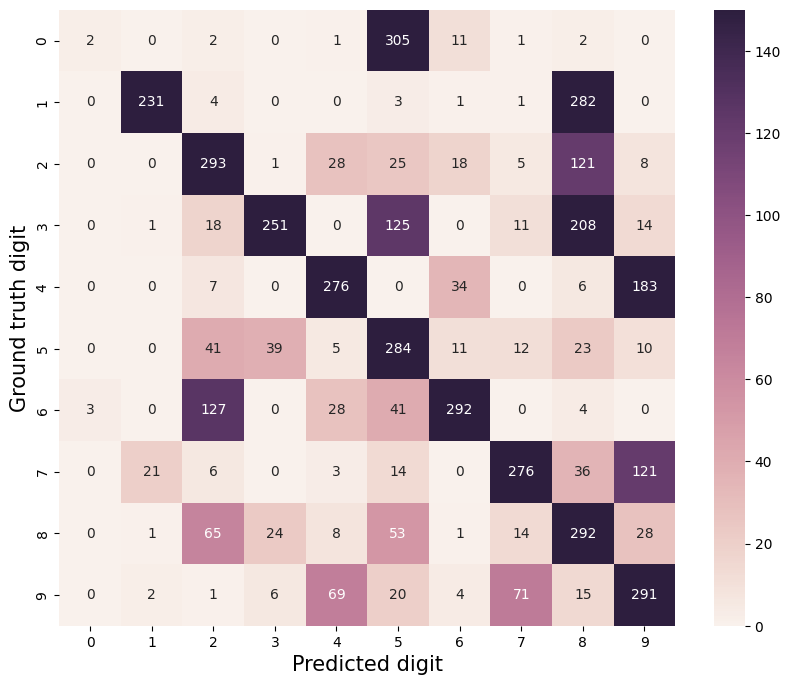

In [ ]:
plot_confusion_matrix(model, mnist_test_dataloader)

Already much better!

### The choice of optimizer

Using plain _stochastic gradient descent_ for updating weights is straightforward, but generally not optimal. 
Modern deep learning almost universally uses extensions such as _root mean squared propagation_ (RMSprop) or _Adam_. The main advantages of these alternatives are that they change the learning rate for each weight individually during training. Each algorithm has its own way of doing so, but it is common to use some type of _momentum_. For example, a weight that is updated in the same direction multiple times in a row will take larger steps at each iteration, while a weight that changes direction frequently will take smaller steps. We will use _RMSprop_.

We only need to update the config object we use to create the model.

In [ ]:
model_config_with_rms = model_config.optimizer(torch.optim.RMSprop, lr=0.001)
model = dl.ImageClassifier.from_config(model_config_with_rms)

In [ ]:
trainer = dl.Trainer(
    max_epochs=5, # How many times to run through the entire dataset
    accelerator="auto", # For now, we use the cpu. Later, we will use the gpu.
)

trainer.fit(model, mnist_train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | backbone     | Sequential | 26.2 K
1 | head         | Sequential | 330   
2 | loss         | MSELoss    | 0     
3 | val_accuracy | Accuracy   | 0     
--------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(model, mnist_train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8964666724205017     │
│         test_loss         │    1.5325441360473633     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8964666724205017, 'test_loss': 1.5325441360473633}]

Another improvement!

### The choice of output activation function

The output representation and loss function can further improve the performance.
As per the output normalization, currently each digit is assigned a probability between 0 and 1 by the network. However, we know that only one classification is true. As such, we can normalize the output such that the prediction sums to one. This is typically done using what is known as _softmax activation_.

We'll complement this with the _cross-entropy loss_, which is a loss function that is commonly used for classification problems. 

However, we cross-entropy loss in `PyTorch` already includes the softmax activation, so we should not apply it twice. We can either

- Use `LogSoftmax` as the activation function in the output layer and `NLLLoss` as the loss function. Here, `NLLLoss` stands for _negative log likelihood loss_, which is the negative of the log of the softmax function. This is equivalent to the cross-entropy loss.
- Use no activation function in the output layer and `CrossEntropyLoss` as the loss function.

In [ ]:
def head_builder(output_activation):
    return torch.nn.Sequential(
        torch.nn.Linear(32, 10),
        output_activation,
    )


model_config_with_cross_entropy = (
    model_config_with_rms
    .head(head_builder)
    .head.output_activation(torch.nn.Identity())
    .loss(torch.nn.CrossEntropyLoss)
)

# Just for demonstration purposes, here is how to use the NLLLoss loss function
# In fact, this is the default behavior of ImageClassifier, so we could just
# not specify the head at all.
model_config_with_nllloss = (
    model_config_with_rms
    .head(head_builder)
    .head.output_activation(torch.nn.LogSoftmax(dim=-1))
    .loss(torch.nn.NLLLoss)
)


model = dl.ImageClassifier.from_config(model_config_with_cross_entropy)
print(model)

ImageClassifier(
  (num_classes): 10
  (backbone): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): Sigmoid()
  )
  (head): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): Identity()
  )
  (loss): CrossEntropyLoss()
  (val_accuracy): Accuracy()
)


In [ ]:
trainer = dl.Trainer(
    max_epochs=5, # How many times to run through the entire dataset
    accelerator="auto", # For now, we use the cpu. Later, we will use the gpu.
)

trainer.fit(model, mnist_train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | backbone     | Sequential       | 26.2 K
1 | head         | Sequential       | 330   
2 | loss         | CrossEntropyLoss | 0     
3 | val_accuracy | Accuracy         | 0     
--------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(model, mnist_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.954800009727478     │
│         test_loss         │    0.15322864055633545    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.954800009727478, 'test_loss': 0.15322864055633545}]

Another big improvement! Let's look at the confusion matrix.

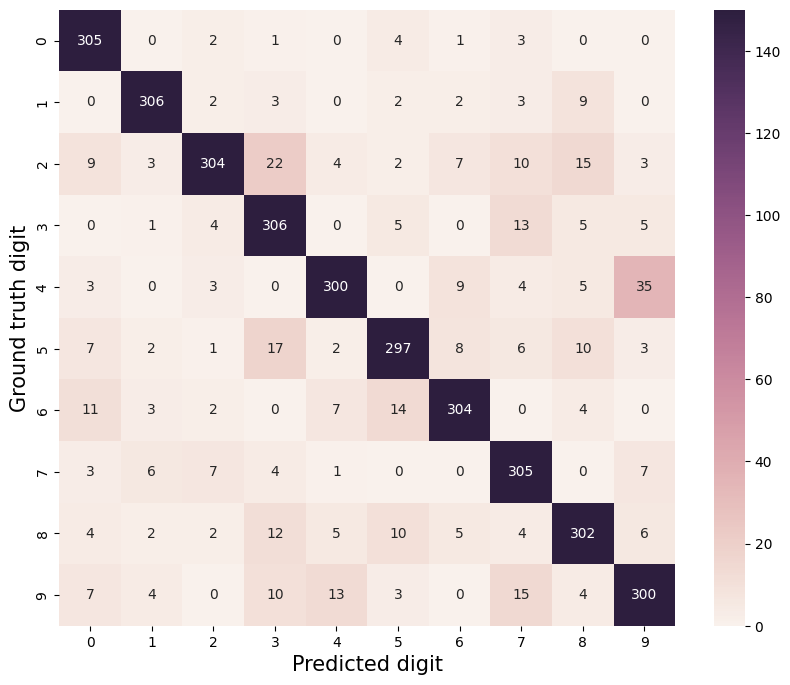

In [ ]:
plot_confusion_matrix(model, mnist_test_dataloader)